# Data Scientist Professional Practical Exam Submission

# 0. Load Modules and Data

## Load Modules

In [1]:
import chardet as ch 
import warnings
import pandas as pd
import numpy as np
import missingno as msno
import random as rnd
import statsmodels.api as sm

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as scistat
import pingouin as pin

from matplotlib import cm

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import normalize, Normalizer, PowerTransformer, OneHotEncoder, QuantileTransformer, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score

from sklearn.linear_model import QuantileRegressor, HuberRegressor, LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

## Set Context and Variables

In [2]:
#plt.style.use('ggplot')
plt.style.use('seaborn-darkgrid')
sns.set_context("notebook")
rnd.seed(42)
np.random.RandomState(42)
warnings.filterwarnings('ignore')

## Load Data

Check CSV file encoding to reduce reading errors and data cleanup

In [3]:
with open('recipe_site_traffic_2212.csv', 'rb') as file:             
    print(ch.detect(file.read()))

{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}


Load data into a Pandas DF

In [4]:
df = pd.read_csv('recipe_site_traffic_2212.csv', encoding = "ascii")    
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


# 1. Data Validation

As specified in the requirements page, the data provided should have the following structure:

Column Name | Type | Details
---------|----------|----------
recipe | Numeric |  unique identifier of recipe
calories | Numeric |  number of calories
carbohydrate | Numeric |  amount of carbohydrates in grams
sugar | Numeric |  amount of sugar in grams
protein | Numeric |  amount of protein in grams
category | Character |  type of recipe. Recipes are listed in one of ten possible groupings (Lunch/Snacks', 'Beverages',  'Potato', 'Vegetable', 'Meat', 'Chicken,  'Pork',  'Dessert', 'Breakfast', 'One Dish Meal').
servings | Numeric |  number of servings for the recipe
high_traffic | Character |  if the traffic to the site was high when this recipewas shown, this is marked with “High”.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


The dataset has 947 rows and 8 columns. It can inmediately be seen that some transformations are needed. There are nulls in the 'calories', 'carbohydrates', 'sugar', 'protein' and 'high_traffic' columns. 'Category' has correctly been read as string column, but 'servings' and 'high_traffic' have not. 

In [6]:
df.describe()

,recipe,calories,carbohydrate,sugar,protein
count,947.000000,895.000000,895.000000,895.000000,895.000000
mean,474.000000,435.939196,35.069676,9.046547,24.149296
std,273.519652,453.020997,43.949032,14.679176,36.369739
min,1.000000,0.140000,0.030000,0.010000,0.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000
50%,474.000000,288.550000,21.480000,4.550000,10.800000
75%,710.500000,597.650000,44.965000,9.800000,30.200000
max,947.000000,3633.160000,530.420000,148.750000,363.360000


In [7]:
df.describe(include='object')

,category,servings,high_traffic
count,947,947,574
unique,11,6,1
top,Breakfast,4,High
freq,106,389,574


There are no negative numbers to the numeric columns, which is a good sign. A value of 0.01 grams might not be reasonable in the scope of a recipe, but I will allow near zero values momentarily. Otherwise nothing seems out of order in the numerical columns without further inspection / visualization.

Checking the raw data for duplicates:

In [8]:
df[df.duplicated()]

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic


There are no duplicated rows in the data.

Inspecting the 'high_traffic' column values:

In [9]:
df['high_traffic'].value_counts()

High    574
Name: high_traffic, dtype: int64

The missing values correspond to just low traffic recipes, which will be later transformed while cleaning the data

Inspecting the 'servings' column:

In [10]:
df['servings'].value_counts()

4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: servings, dtype: int64

Here we see some extra wording ['as a snack'] that can be dismissed in order to convert the column directly to numerical value

As for the 'recipe' column: 

In [11]:
df['recipe'].nunique()

947

It has the exact number of rows of the data. Taking a look at the tail of it:

In [12]:
df.tail()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
942,943,1161.00,5.31,22.39,44.22,Lunch/Snacks,2,NaN
943,944,NaN,NaN,NaN,NaN,Potato,2,High
944,945,951.74,29.42,3.57,13.87,Pork,2,High
945,946,266.61,35.77,0.97,8.07,Potato,6,High
946,947,184.56,45.21,6.20,0.03,Beverages,4,NaN


It can be seen that the 'recipe' column monotonically increases. Thus it can either be dropped or be used as an index (which will probably better serve the product manager later in their integration of our prediction with the website production code).

And finally taking a look at the category column:

In [13]:
df['category'].value_counts()

Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Vegetable          83
Dessert            83
Meat               79
Chicken            74
One Dish Meal      71
Name: category, dtype: int64

It can be seen that there are 11 categories, whereas the data dictionary tells us there should only be 10. 'Chicken Breast' rows will be merged into the 'Chicken' category.

**In summary**:  
    a. The data consists of 947 rows and 8 columns.  
    b. There are missing values in the numerical columns which will need to be imputed.  
    c. The dataset has no duplicated values.  
    d. The 'high_traffic' column nulls correspond to low traffic recipes.  
    e. The 'servings' column needs to be cleaned of the string 'as a snack' and be converted to numerical.  
    f. The 'recipe' column should be promoted to the index of the dataset.  
    g. The 'category' column has an extra category, 'Chicken Breast', which needs to be converted to 'Chicken'.  

# 2. Data Clean-up

In order to prevent data leakage from train set to test set, only the most inoffensive operations will be performed before train/test split:  
    a. Convert 'high_traffic' to boolean assigning *"True"* to 'High' and *"False"* to the nulls.  
    b. Clean 'servings' column and convert to numerical.  
    c. Promote 'recipe to index.  
    d. Convert 'Chicken Breast' to 'Chicken' in the 'category' column.  

## 2a. 'high_traffic' Column

Let's convert the 'high_traffic' column to a boolean column, where High -> True and otherwise it was False

In [14]:
df.high_traffic = df.high_traffic.apply(lambda x: True if x == 'High' else False)
df['high_traffic'].value_counts()/len(df)*100

True     60.61246
False    39.38754
Name: high_traffic, dtype: float64

The target column is not terrribly unbalanced (60/40). It should be noted that perhaps bootstraping and resampling will be needed to boost the low recipe rows in order to improve model predictions. 

## 2b. 'servings' Column

Substitute the whole phrase "# as a snack" with the servings value:

In [15]:
df.loc[df['servings'] == '6 as a snack', 'servings']  = '6'
df.loc[df['servings'] == '4 as a snack', 'servings']  = '4'

## 2c. 'recipe' Column

Set the 'recipe' column as the index

In [16]:
df.set_index('recipe', inplace=True)

## 2d. 'category' Column

Substitute 'Chicken Breast' for 'Chicken'

In [17]:
df['category'] = df['category'].str.replace('Chicken Breast', 'Chicken')

Finally, let's convert 'servings' to integer and 'category' to categorical:

In [18]:
convert_dtypes = {'servings':'int32', 'category': 'category'}
df = df.astype(convert_dtypes)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947 entries, 1 to 947
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   calories      895 non-null    float64 
 1   carbohydrate  895 non-null    float64 
 2   sugar         895 non-null    float64 
 3   protein       895 non-null    float64 
 4   category      947 non-null    category
 5   servings      947 non-null    int32   
 6   high_traffic  947 non-null    bool    
dtypes: bool(1), category(1), float64(4), int32(1)
memory usage: 42.9 KB


In [19]:
df.head()

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
recipe,,,,,,,
1,NaN,NaN,NaN,NaN,Pork,6,True
2,35.48,38.56,0.66,0.92,Potato,4,True
3,914.28,42.68,3.09,2.88,Breakfast,1,False
4,97.03,30.56,38.63,0.02,Beverages,4,True
5,27.05,1.85,0.80,0.53,Beverages,4,False


# 3. Data Exploration

The data as is is incomplete: there are nulls that need to be inputed, and we still do not know the distributions of the numerical columns or if there are any evident dependencies between the variables. However, before proceeding with more complicated manipulations, let's take a look at the data as it is.

## Exploration of Variables

Plotting the distribution of numerical variables:

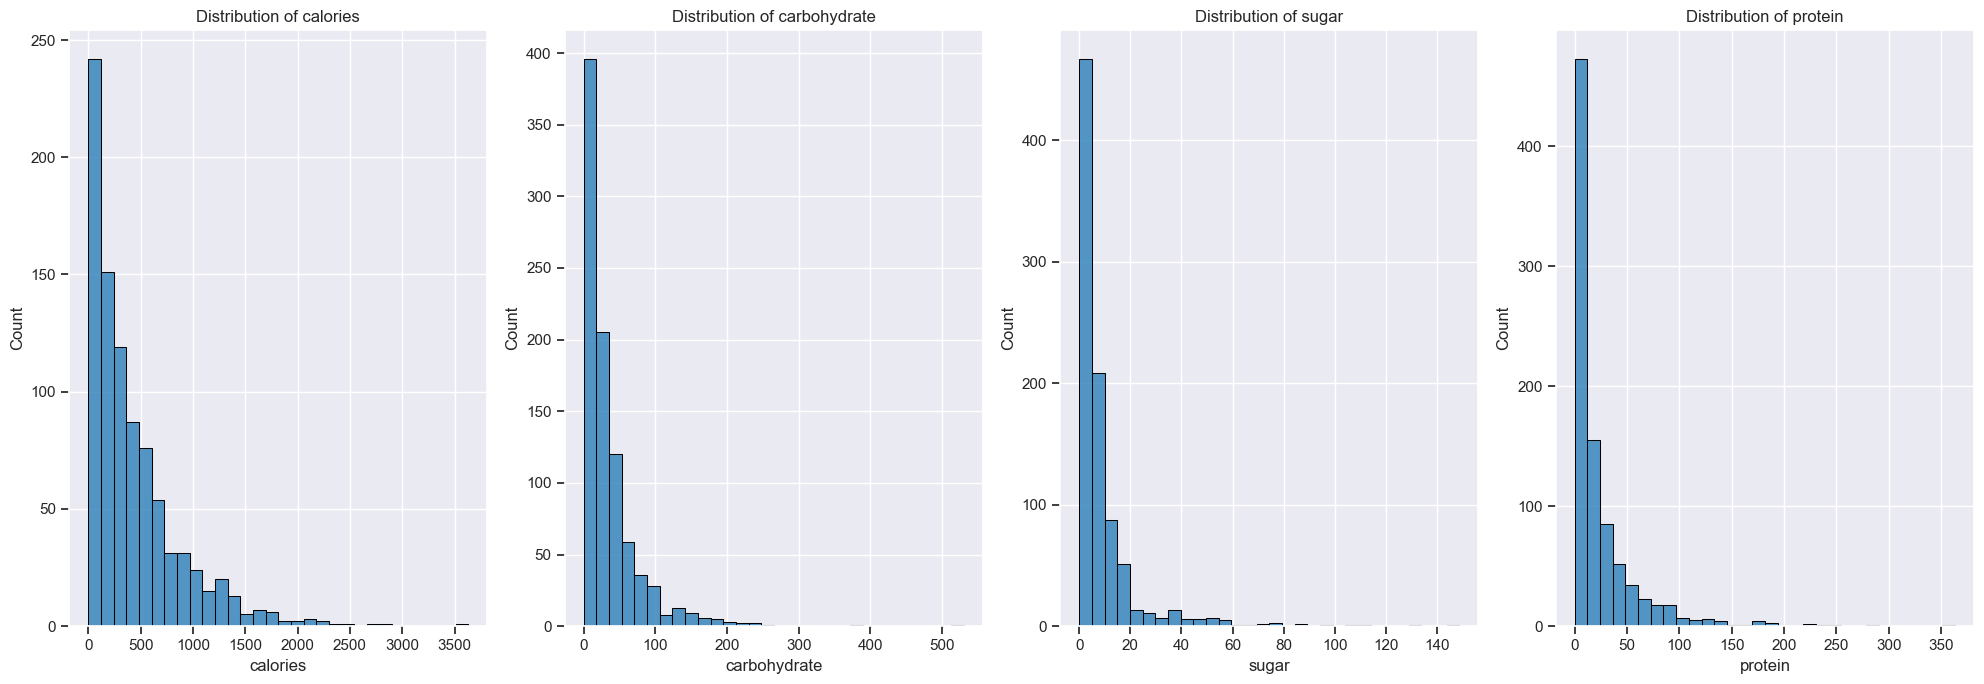

In [20]:
numeric_cols = ['calories', 'carbohydrate', 'sugar', 'protein']

fig, axs = plt.subplots(1,4, figsize=(20,7))

for idx, col in enumerate(numeric_cols):
    sns.histplot(df[col], kde = False, bins = 30, ax = axs[idx])
    axs[idx].set_title(f'Distribution of {col}')
    
plt.tight_layout()
plt.show()

Plotting the distribution of categorical variables:

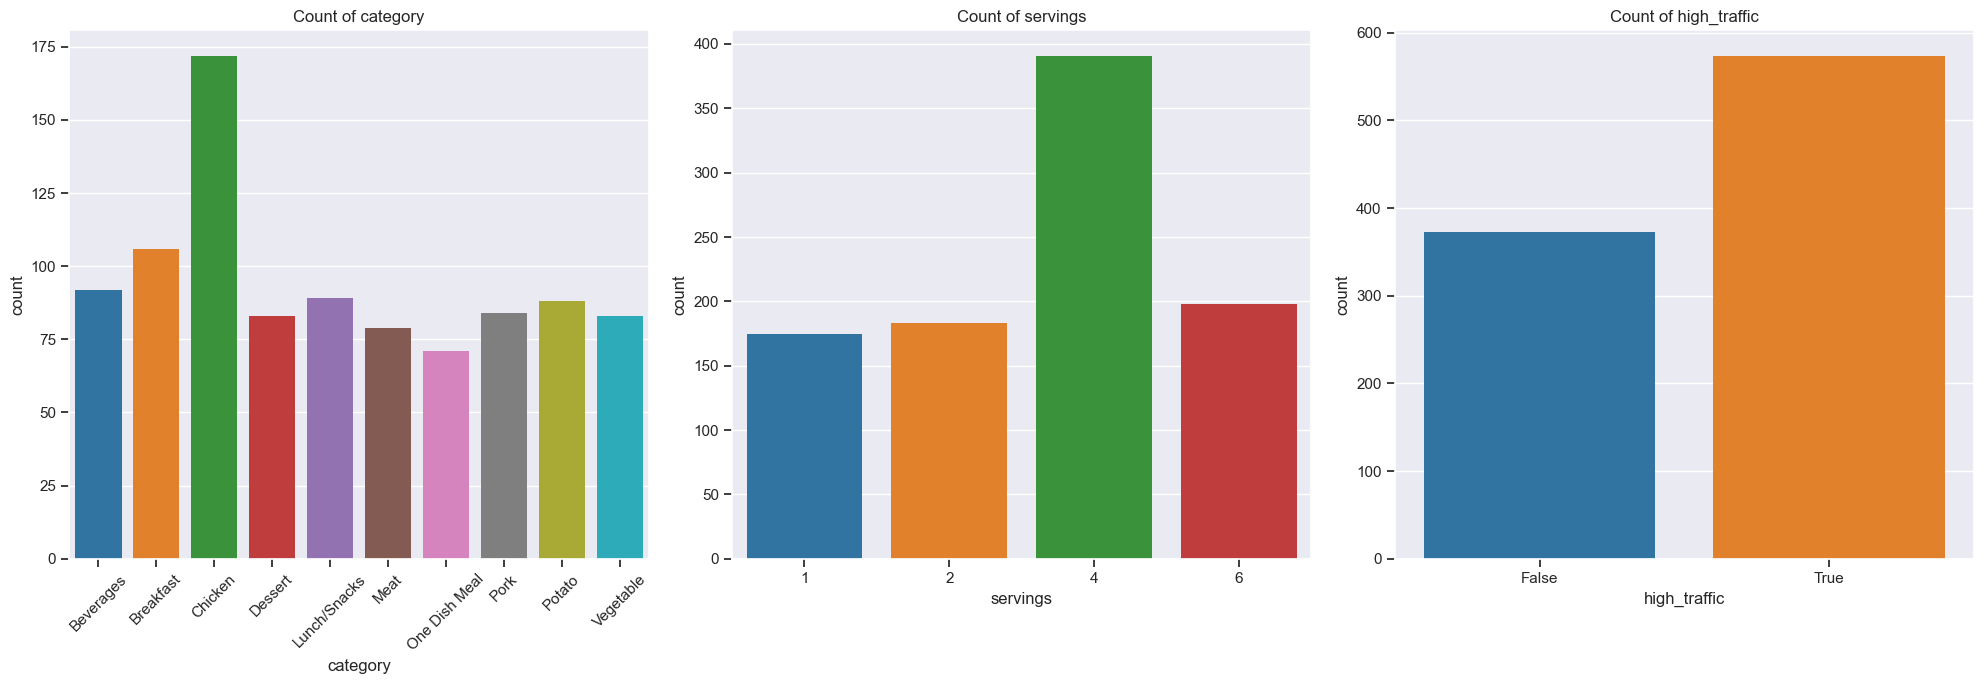

In [21]:
categorical_cols = ['category','servings', 'high_traffic']

fig, axs = plt.subplots(1,3, figsize=(20,7))

for idx, col in enumerate(categorical_cols):
    sns.countplot(x=col, data=df, ax=axs[idx])
    axs[idx].set_title(f'Count of {col}')
    if col == 'category':
        for label in axs[idx].get_xticklabels():
            label.set_rotation(45)

plt.tight_layout()
plt.show()

There is a some unbalancing of the 'Chicken' category, and of the '4' servings values. If needed, we could resample to return these distributions to a uniform distribution. The same for the target variable.

Plotting categories against servings:

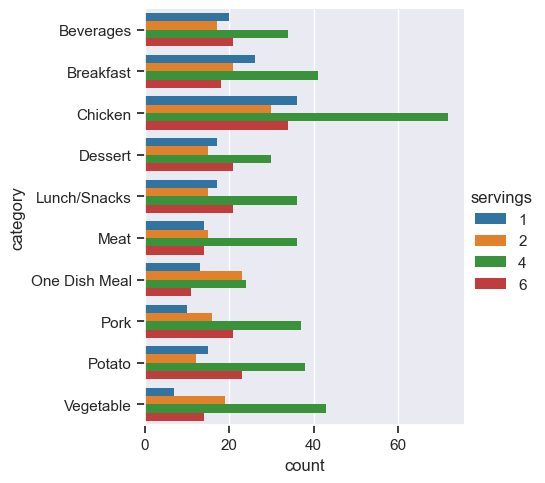

In [22]:
sns.catplot(
    data=df, y="category", hue="servings",
    kind="count"#, aspect=2, fliersize=2, dodge = True
    #palette = 'Set1',
)

There is nothing remarkable to add, apart from the unbalanced 'Chicken' + '4 Servings' group 

Let's boxplot the numeric variables to get a sense of how the outliers are behaving:

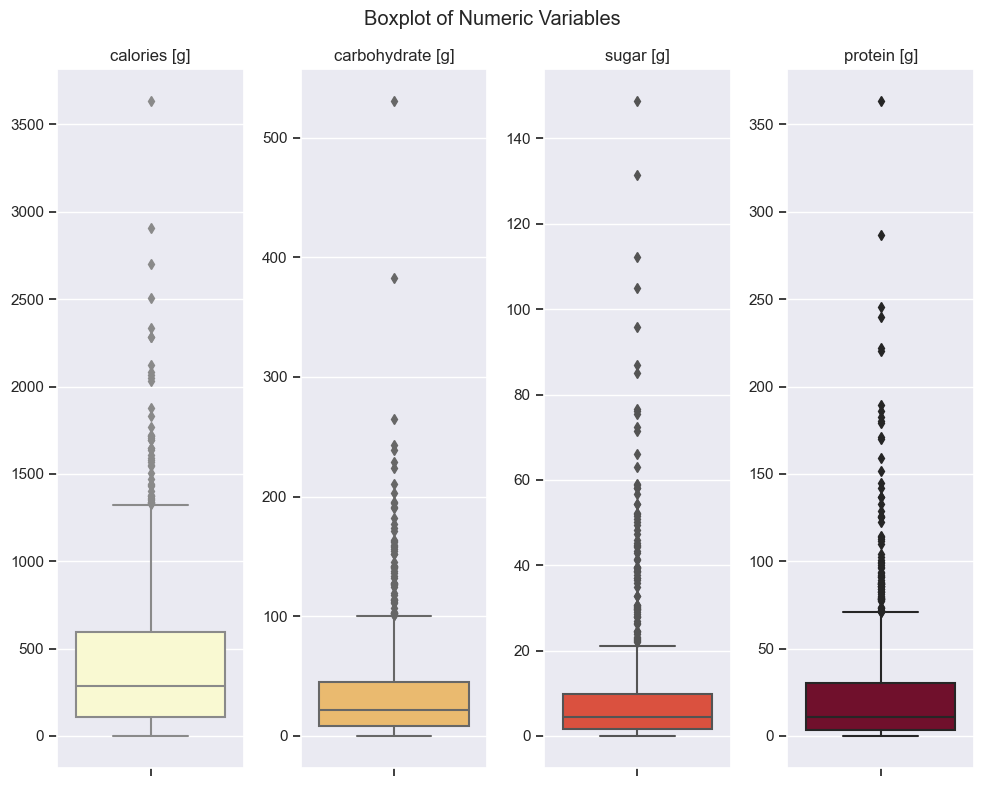

In [23]:
color_map = cm.get_cmap('YlOrRd', 4)

fig, axs = plt.subplots(1, len(numeric_cols), figsize=(10, 8))

for idx, col in enumerate(numeric_cols):
    sns.boxplot(y = df[col], ax = axs[idx], color = color_map(idx))
    axs[idx].set_title(f'{col} [g]')
    axs[idx].set(ylabel=None)

fig.suptitle('Boxplot of Numeric Variables')
plt.tight_layout()
plt.show()

There are clear outliers about the interquartile edge, so outlier treatment will have to be performed.

## Exploration of Relations to Target Column

Let's take a look at the numerical values in a pairplot and how they divide according to 'high_traffic'

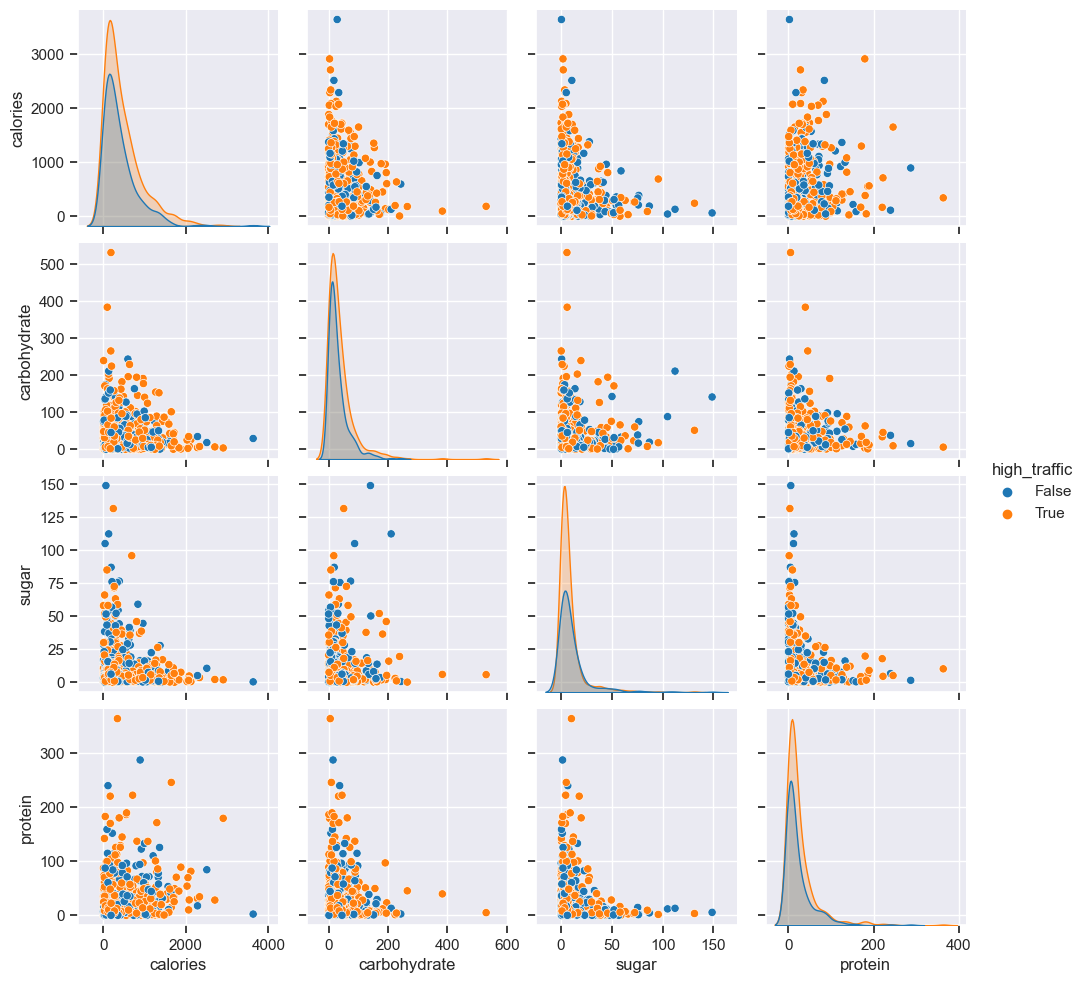

In [24]:
sns.pairplot(data = df.drop('servings', axis=1), hue = 'high_traffic')

There is no discernable dependecy of the pairwise numerical variables w.r.t high_traffic, appart from the rightly skewed dsitributions. There seems to be a small density bumb on the right tail, perhaps indicating how this data was previously scaled, but nothing here denotes a clear pattern which to exploit or account for.

Plotting 'servings' against 'high_traffic':

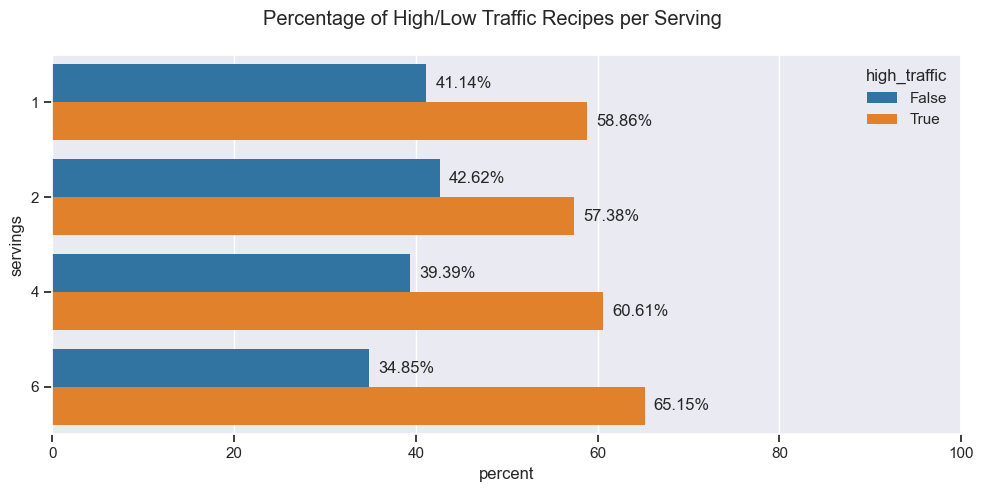

In [25]:
df_plot = df.groupby('servings')['high_traffic'].value_counts(normalize = True)
df_plot = df_plot.mul(100)
df_plot = df_plot.rename('percent').reset_index()
df_plot['servings'] = df_plot['servings'].values.astype(str)

fig, ax = plt.subplots(figsize=(10, 5))

sns.barplot(y = 'servings', x ='percent', hue = 'high_traffic', data=df_plot, ax = ax)

ax.set_xlim(0,100)
fig.suptitle('Percentage of High/Low Traffic Recipes per Serving')

for p in ax.patches:
    txt = str(p.get_width().round(2)) + '%'
    txt_y = p.get_y() + 0.25
    txt_x = p.get_width() + 1
    ax.text(txt_x,txt_y,txt)

plt.tight_layout()
plt.show()

We can see that for all servings we have more high traffic recipes than low traffic. The distribution follows a nice uniform patter, but apart from the imbalance, nothing else should be noted here.

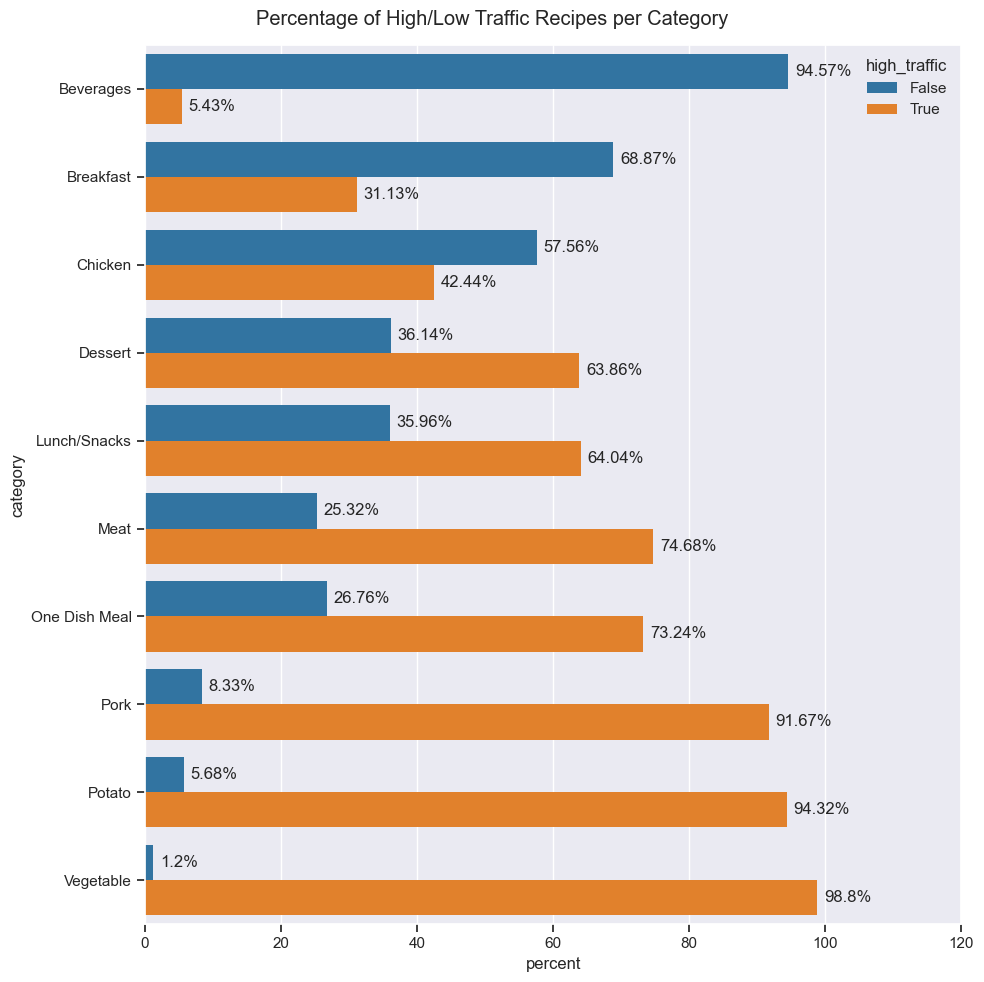

In [26]:
df_plot = df.groupby('category')['high_traffic'].value_counts(normalize = True)
df_plot = df_plot.mul(100)
df_plot = df_plot.rename('percent').reset_index()

fig, ax = plt.subplots(figsize=(10, 10))

sns.barplot(y = 'category', x ='percent', hue = 'high_traffic', data=df_plot, ax = ax)
ax.set_xlim(0,120)
fig.suptitle('Percentage of High/Low Traffic Recipes per Category')

for p in ax.patches:
    txt = str(p.get_width().round(2)) + '%'
    txt_y = p.get_y() + 0.25
    txt_x = p.get_width() + 1
    ax.text(txt_x,txt_y,txt)

plt.tight_layout()
plt.show()

Here we have a clear first pattern in our data:  
**Pork, Potato and Vegetable** recipes lead clearly to higher traffice to the rest of the site. Could this imbalance lead to a bias in the later model development and evaluation?

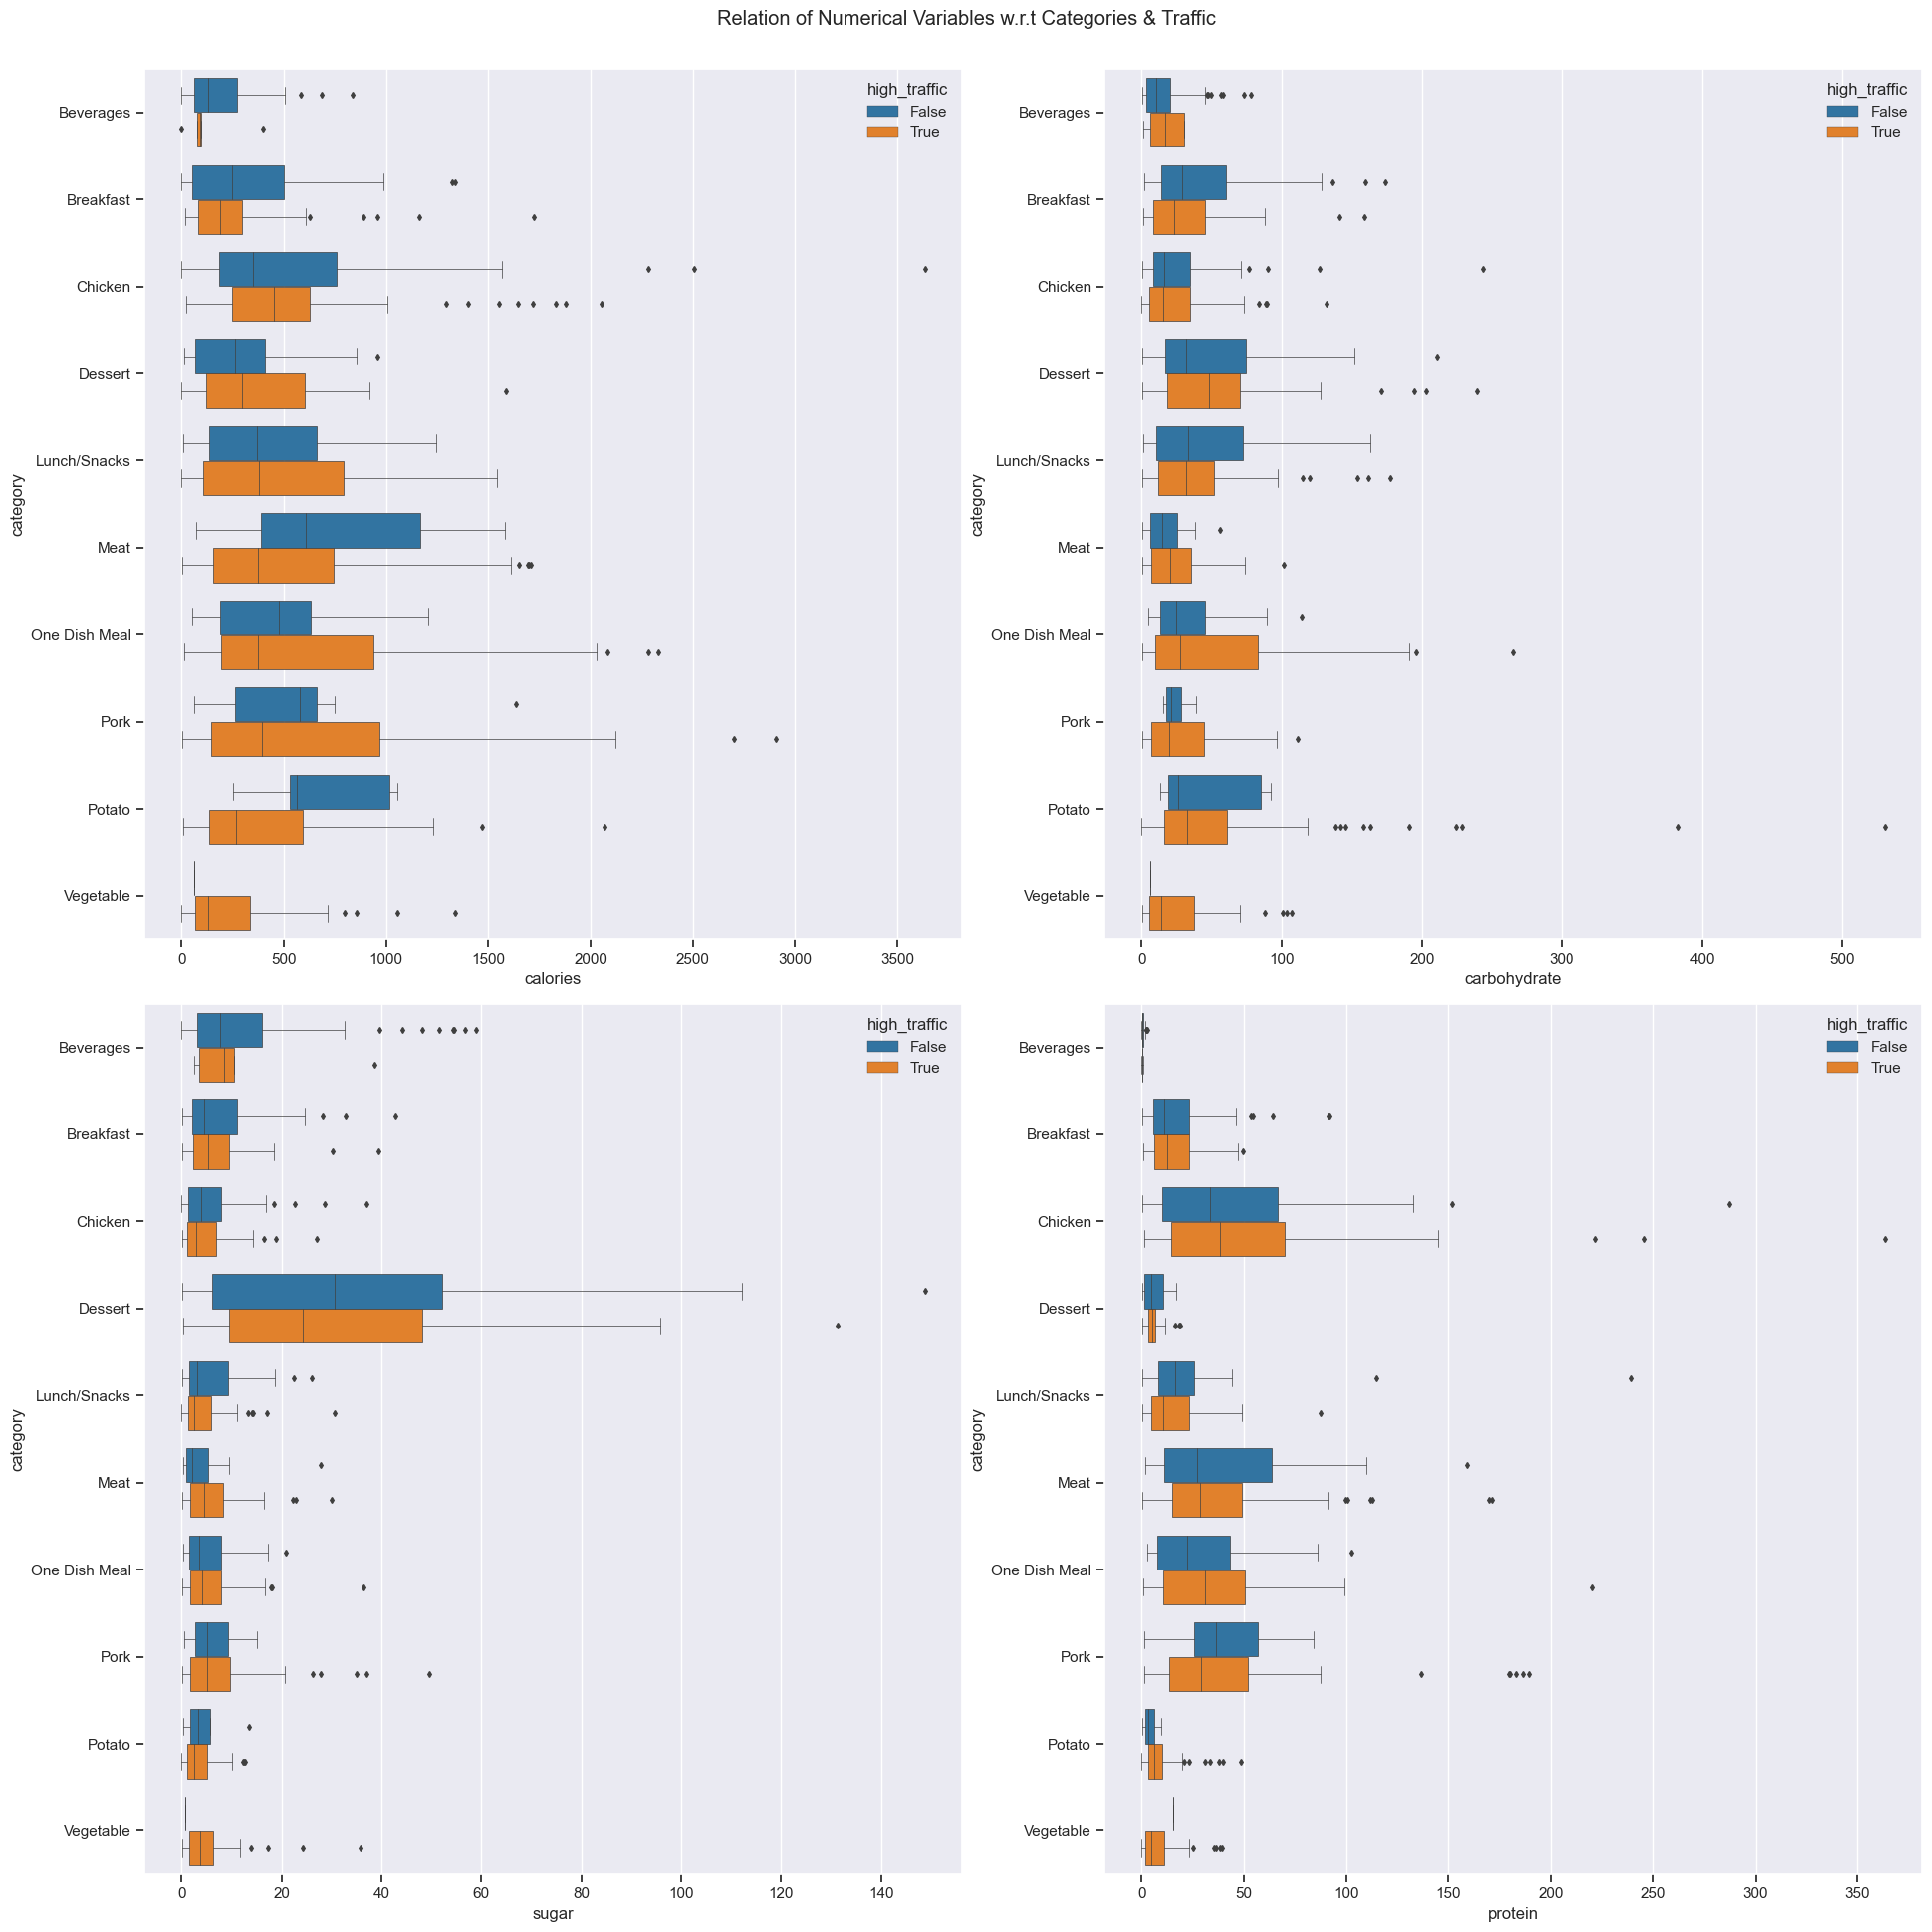

In [27]:
fig, axs = plt.subplots(2,2, figsize=(20,20))
fig.suptitle('Relation of Numerical Variables w.r.t Categories & Traffic')

cat_order = {}

for idx, col in enumerate(numeric_cols):
    # Create i, j indices to place the graphs accordingly
    i, j = divmod(idx, 2)
    
    # Find the order of the categories decreasing by median
    # cat_order[col] = df.groupby("category")[col].mean().iloc[::-1].index.tolist()
    
    sns.boxplot(
        data=df, x=col, y="category", hue="high_traffic",
        fliersize=3, dodge = True, linewidth=0.5,
        #palette = 'Set1', kind="box", aspect=2, order = cat_order[col]
        flierprops={"color": 'red'}, ax = axs[i,j]
    )

plt.tight_layout(pad=2.4, w_pad=0.5, h_pad=1.0)
plt.show()

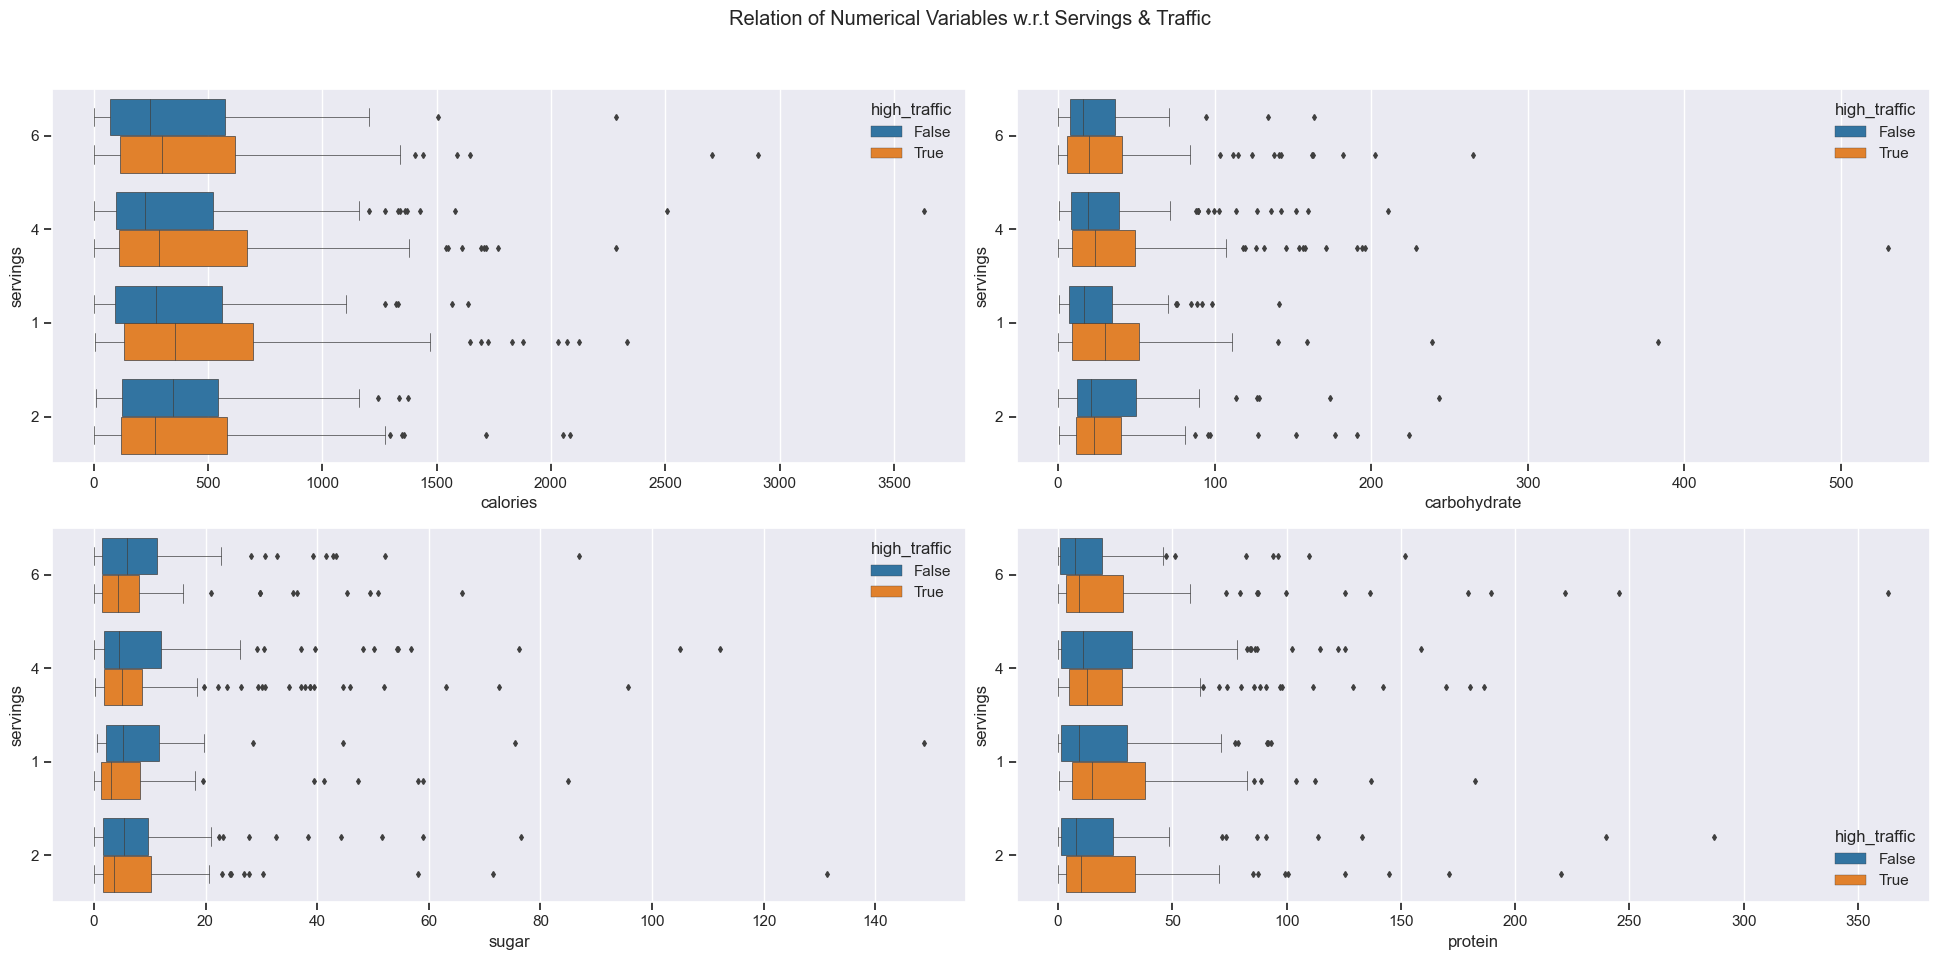

In [28]:
df_plot = df.copy()
df_plot['servings'] = df_plot['servings'].values.astype(str)

fig, axs = plt.subplots(2,2, figsize=(20,10))
fig.suptitle('Relation of Numerical Variables w.r.t Servings & Traffic')

cat_order = {}

for idx, col in enumerate(numeric_cols):
    # Create i, j indices to place the graphs accordingly
    i, j = divmod(idx, 2)
    
    # Find the order of the categories decreasing by median
    # cat_order[col] = df.groupby("category")[col].mean().iloc[::-1].index.tolist()
    
    sns.boxplot(
        data=df_plot, x=col, y="servings", hue="high_traffic",
        fliersize=3, dodge = True, linewidth=0.5,
        #palette = 'Set1', kind="box", aspect=2, order = cat_order[col]
        flierprops={"color": 'red'}, ax = axs[i,j]
    )

plt.tight_layout(pad=2.4, w_pad=0.5, h_pad=1.0)
plt.show()

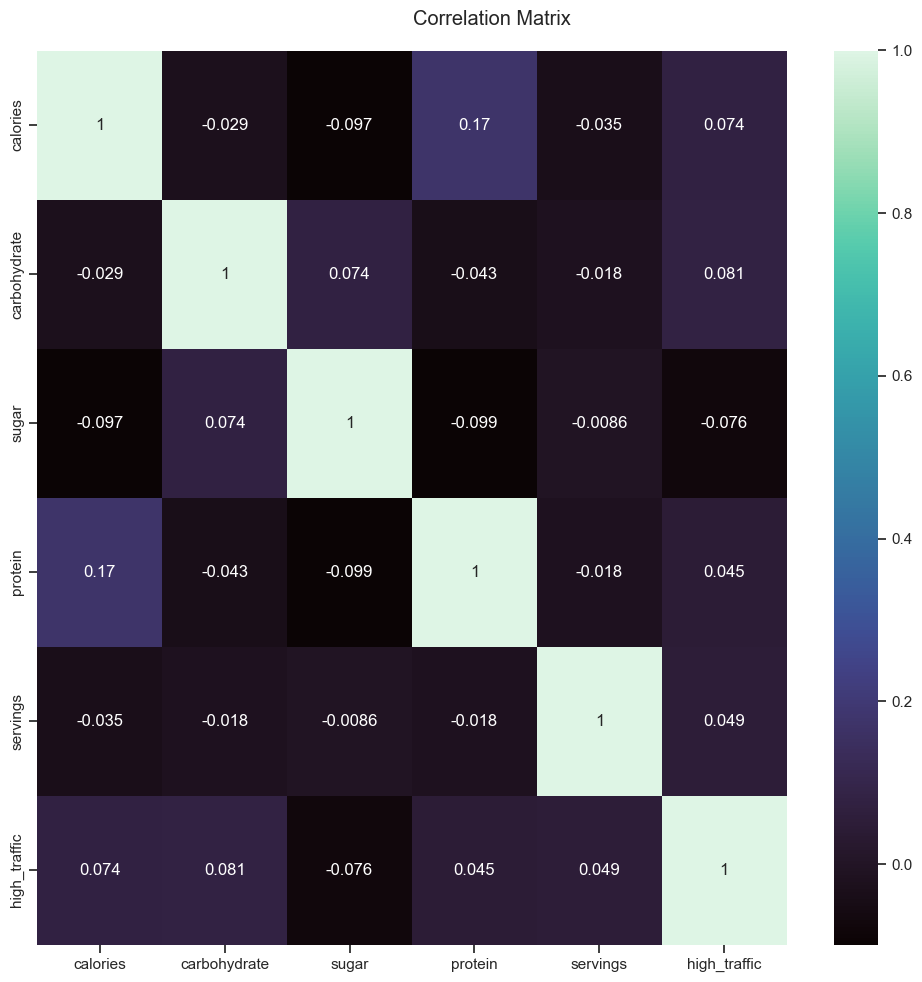

In [29]:
correlation = df.corr(numeric_only = True)

fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(correlation, vmax=1, annot = True, cmap='mako', ax = ax)

fig.suptitle('Correlation Matrix')
plt.tight_layout()
plt.show()

# 4. Preprocessing

## Split into Train/Test Sets

Before applying more complex transformations, let's split the data into train/test sets in order to prevent information leakage between the sets and minimize the bias the models will be exposed to at testing time.

In [30]:
X = df.drop("high_traffic", axis=1)
y = df['high_traffic']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

All complex transformations will be fitted with the train set first, and then the test set will be transformed without refitting the transformations.

## Missing Value Treatment

Counting the total missing values in our train set:

In [32]:
X_train.isnull().sum()

calories        41
carbohydrate    41
sugar           41
protein         41
category         0
servings         0
dtype: int64

And evaluating their percentage per variable:

In [33]:
X_train.isnull().sum().sort_values(ascending=False)/len(X_train)*100

calories        5.774648
carbohydrate    5.774648
sugar           5.774648
protein         5.774648
category        0.000000
servings        0.000000
dtype: float64

It can be seen that the percentage is a little above the orthodox threshold for dropping the missing values, so we will treat them with some robust techniques.

In [34]:
X_train[X_train.isnull().any(axis=1)]

,calories,carbohydrate,sugar,protein,category,servings
recipe,,,,,,
213,NaN,NaN,NaN,NaN,Dessert,4
1,NaN,NaN,NaN,NaN,Pork,6
352,NaN,NaN,NaN,NaN,Potato,4
891,NaN,NaN,NaN,NaN,Meat,4
539,NaN,NaN,NaN,NaN,Vegetable,4
355,NaN,NaN,NaN,NaN,Pork,4
279,NaN,NaN,NaN,NaN,Lunch/Snacks,4
531,NaN,NaN,NaN,NaN,Vegetable,1
535,NaN,NaN,NaN,NaN,Chicken,2


It is also worth noting that the missing values come from a systemic error: all missing values correspond to a row where all the numeric values are missing. However, 'category' and 'servings' are still present, thus we cannot simply drop them and disregard this information. In order to take advantage of this info, we will impute the missing values by grouping the train set by 'category' and 'servings', computing the median for each group, and using the corresponding category/serving median to impute the missing numerical columns for these rows.

Gathering the medians per category/serving of the train set and inspecting the first rows:

In [35]:
grp_medians = X_train.groupby(['category', 'servings']).median()
print(grp_medians.head())

                    calories  carbohydrate  sugar  protein
category  servings                                        
Beverages 1          184.320         7.370  9.800    0.380
          2          183.475        13.780  6.695    0.545
          4          138.915        12.415  9.885    0.310
          6           92.610         6.270  5.100    0.360
Breakfast 1          336.000        26.240  4.620   19.400


The we will impute all missing data using this train set group median dataset

In [36]:
for col in numeric_cols:
    for cat, srv in grp_medians.index:
        X_train.loc[(X_train['category'] == cat) & (X_train['servings'] == srv), col] = X_train.loc[(X_train['category'] == cat) & (X_train['servings'] == srv), col].fillna(grp_medians.loc[cat, srv][col])
        
        X_test.loc[(X_test['category'] == cat) & (X_test['servings'] == srv), col] = X_test.loc[(X_test['category'] == cat) & (X_test['servings'] == srv), col].fillna(grp_medians.loc[cat, srv][col])


print( 'Missing values in X_train: ')  
print(X_train.isnull().sum())
print( '----')  
print( 'Missing values in X_test: ')  
print(X_test.isnull().sum())

Missing values in X_train: 
calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
dtype: int64
----
Missing values in X_test: 
calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
dtype: int64


## Outlier Treatment

Outlier strategy:  
1. Identify outliers using IQR method
2. Set those outliers to NaN
3. Impute missing values using a robust estimator (Linear Quantile, Huber Regressor, Andrew) 
4. Compare data w/ OrigOuliers and w/ ImputedOuliers
5. Apply transformations to train and test set

In [37]:
def get_quantiles(df):
    q1 = df.quantile(0.25)
    q3 = df.quantile(0.75)
    quantiles = [q1, q3]
    return quantiles

def get_outliers(df, quantiles):
    IQR = quantiles[1] - quantiles[0]
    outliers = ((df < (quantiles[0] - 1.5 * IQR)) | (df > (quantiles[1] + 1.5 * IQR)))    
    return outliers

X_train_num = X_train[numeric_cols].copy()
X_test_num = X_test[numeric_cols].copy()

quants_train = get_quantiles(X_train_num)
outs_idx_train = get_outliers(X_train_num, quants_train)
outs_idx_test = get_outliers(X_test_num, quants_train)

In [38]:
IQR = quants_train[1] - quants_train[0]
print('---- Right IQR Percentile per Column')
for col in numeric_cols:
    print(col + " = ", np.round(scistat.percentileofscore(X_train_num[col], quants_train[1][col] + (1.5*IQR[col])),2))
    
print('---- Number of Outliers per Column')
print(outs_idx_train.sum(axis = 0))
print('---- Percent of Outliers per Column')
print(np.round(outs_idx_train.sum(axis = 0)*100/len(X_train_num),2))

---- Right IQR Percentile per Column
calories =  93.66
carbohydrate =  93.38
sugar =  90.99
protein =  91.13
---- Number of Outliers per Column
calories        45
carbohydrate    47
sugar           64
protein         63
dtype: int64
---- Percent of Outliers per Column
calories        6.34
carbohydrate    6.62
sugar           9.01
protein         8.87
dtype: float64


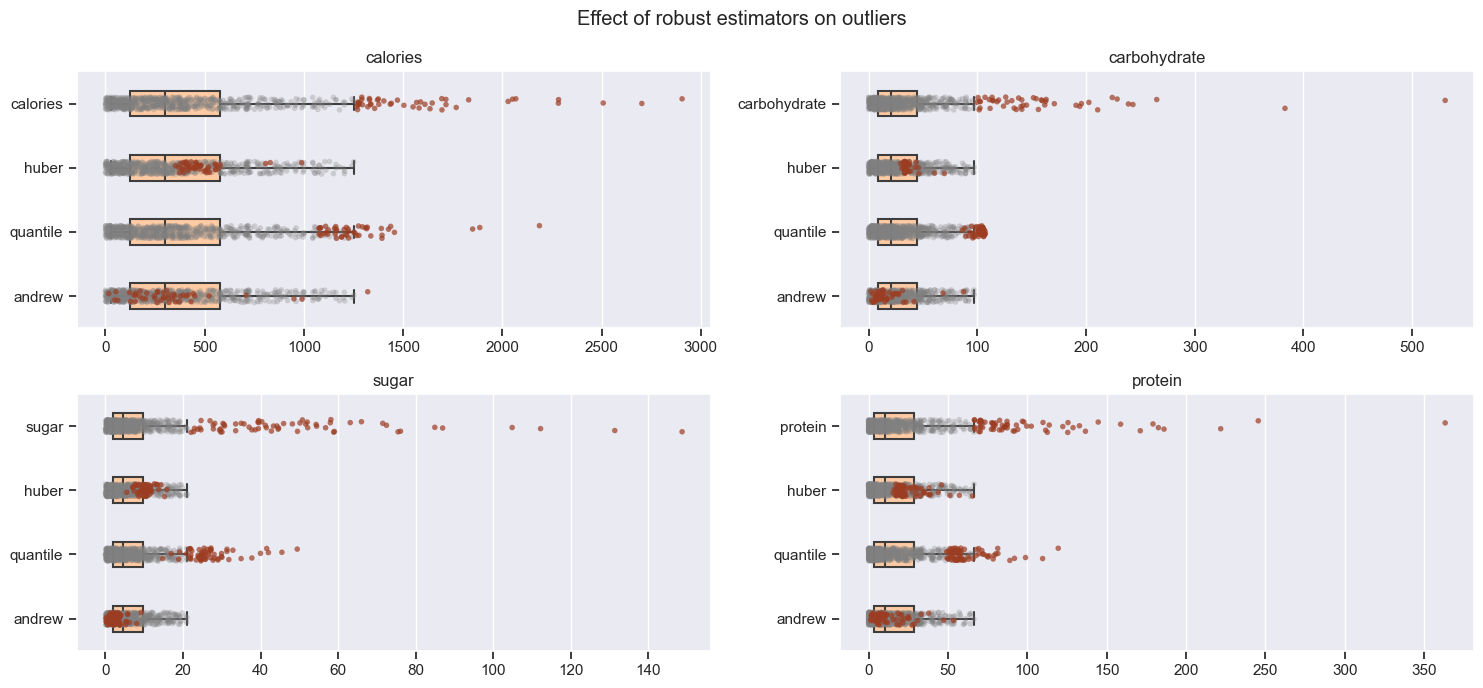

In [39]:
def plot_outlier_transformations(X_train_num, numeric_cols, outs_idx_train, quants_train):
    # Train a robust regressor on a given column to transform outlier values to a more sensible value, based on the other numeric columns 
    outs_preds = {}

    fig, axs = plt.subplots(2,2, figsize=(15,7))
    fig.suptitle('Effect of robust estimators on outliers')
    for idx, col in enumerate(numeric_cols):
        # Split X_train into 'y' with imputation column and X w/o imputation columns
        X_imp = X_train_num.loc[:, X_train_num.columns != col]
        y_imp = X_train_num.loc[:, X_train_num.columns == col]
        
        n_col_outliers = outs_idx_train[col].sum()   
        right_quant = scistat.percentileofscore(X_train_num[col], quants_train[1][col]+1.5*IQR[col])

        # Train Robust models on X
        huber = HuberRegressor(max_iter = 1000, alpha = 250, epsilon = n_col_outliers/2).fit(X_imp, y_imp.values.ravel())
        qtreg = QuantileRegressor(quantile = right_quant/100,  alpha=0.4, solver='highs').fit(X_imp, y_imp.values.ravel()) # 1.5 * IQR in Quantiles
        andrew = sm.RLM(y_imp.values.ravel(), X_imp, M = sm.robust.norms.AndrewWave())
        andrew_res = andrew.fit()

        # Extract outliers and outliers' context from X_imp
        X_imp_outs = X_imp.loc[outs_idx_train[col], :]
        y_imp_outs = y_imp.loc[outs_idx_train[col], :].copy()

        # Predict outlier 'col' values based on models and their context
        outs_preds[col + '_huber'] = huber.predict(X_imp_outs)
        outs_preds[col + '_qtreg'] = qtreg.predict(X_imp_outs)
        outs_preds[col + '_andrew'] = andrew_res.predict(X_imp_outs)
        
        ## Reconstruct X_imp with inliers and predicted outliers values
        # Extract inliers and inliers' context from X_imp
        X_imp_ins = X_imp.loc[~outs_idx_train[col], :]
        y_imp_ins = y_imp.loc[~outs_idx_train[col], :]

        #y_imp_outs = pd.concat([y_imp_outs, y_imp_ins])
        y_imp_outs.loc[:, col + '_h_pred'] = np.round(outs_preds[col + '_huber'], 2)
        y_imp_outs.loc[:, col + '_q_pred'] = np.round(outs_preds[col + '_qtreg'], 2)
        y_imp_outs.loc[:, col + '_a_pred'] = np.round(outs_preds[col + '_andrew'], 2)
        y_imp_outs.loc[:, col + '_outlier'] = outs_idx_train.loc[outs_idx_train[col],col]

        y_imp_ins_ext = {col : y_imp_ins[col],
                        col + '_h_pred': y_imp_ins[col], 
                        col + '_q_pred': y_imp_ins[col],
                        col + '_a_pred': y_imp_ins[col],
                        col + '_outlier' : outs_idx_train.loc[~outs_idx_train[col], col]}
        y_imp_ins_ext = pd.DataFrame(y_imp_ins_ext)

        # Reconstruct the X_imp and y_imp
        y_imp_rc = pd.concat([y_imp_outs, y_imp_ins_ext])
        X_imp_rc = pd.concat([X_imp_outs, X_imp_ins])
        
        y_boxplot_base = {col : y_imp_rc[col],
                        col + '_h_pred': y_imp_rc[col], 
                        col + '_q_pred': y_imp_rc[col],
                        col + '_a_pred': y_imp_rc[col]}
        y_boxplot_base = pd.DataFrame(y_boxplot_base)

        # Plot the effect of the transformations on the outliers
        i, j = divmod(idx, 2)
        axs[i, j].set_title( col )
        sns.boxplot(y_boxplot_base, 
                    orient = 'h', 
                    whis=[5, right_quant], 
                    width=.4, 
                    fliersize = 0,
                    boxprops={"facecolor": '#FFCBA4'}, 
                    ax=axs[i, j])
        sns.stripplot(y_imp_rc.loc[y_imp_rc[col + '_outlier'] == False, 
                                    y_imp_rc.columns != col + '_outlier'], 
                    alpha=.3, 
                    palette=['grey', 'grey', 'grey', 'grey' ], 
                    orient="h", 
                    size = 4, 
                    ax=axs[i, j])
        sns.stripplot(y_imp_rc.loc[y_imp_rc[col + '_outlier'] == True, 
                                    y_imp_rc.columns != col + '_outlier'], 
                    alpha=.7, 
                    palette=['#9C3D22', '#9C3D22', '#9C3D22', '#9C3D22' ], 
                    orient="h", 
                    size =  4, 
                    ax=axs[i, j])
        axs[i, j].set(yticklabels=[col, 'huber', 'quantile', 'andrew'])
        
    plt.tight_layout()
    plt.show()
    

plot_outlier_transformations(X_train_num, numeric_cols, outs_idx_train, quants_train)

The most sensible outlier treatment seems to be the transformation provided by a quantile regression. The quantile regression columns will be selected as the accepted transformed outliers.

In [40]:
def transform_outs(df, outliers, cols, quantiles, model = []):
    y_outs_preds = {}
    model_out = {}
    df_out = pd.DataFrame()
    
    IQR = quantiles[1] - quantiles[0]
    
    for idx, col in enumerate(cols):
        # Split X_train into 'y' with imputation column and X w/o imputation columns
        X = df.loc[:, df.columns != col]
        y = df.loc[:, df.columns == col]
        
        if model == []:
        # Train Quantile models on X
            right_quant = scistat.percentileofscore(df[col], quantiles[1][col]+1.5*IQR[col])
            qtreg = QuantileRegressor(quantile = right_quant/100,  alpha=0.4, solver='highs').fit(X, y.values.ravel()) # 1.5 * IQR in Quantiles
            model_out[col] = qtreg
        else:
            qtreg = model[col]

        # Extract outliers and outliers' context from X
        X_outs = X.loc[outliers[col], :]
        y_outs = y.loc[outliers[col], :]
        
        # Extract inliers and inliers' context from X
        X_ins = X.loc[~outliers[col], :]
        y_ins = y.loc[~outliers[col], :]

        # Predict outlier 'col' values based on model and their context
        y_outs_preds[col] = np.round(qtreg.predict(X_outs), 2)
        y_outs_df = pd.DataFrame({col:y_outs_preds[col]}, index = X_outs.index )
        
        # Reconstruct y with inliers and predicted outliers values
        y_rc = pd.concat([y_outs_df, y_ins])
        
        #print(y_rc)
        assert ~(y_rc.index.has_duplicates)
        
        df_out = pd.concat([df_out, y_rc], axis = 1)
        
    return df_out, model_out

X_train[numeric_cols], qmod_train = transform_outs(X_train_num, outs_idx_train, numeric_cols, quants_train, model = [])

X_test[numeric_cols], qmod_train = transform_outs(X_test_num, outs_idx_test, numeric_cols, quants_train, model = qmod_train)


## Power Transformation

First we will look at the skewness of the feature variables. Higher than 0 skew values, or extremely low p-values in the skewtest suggest our data might be skewed (reject null hypothesis).

In [41]:
skew_table = [scistat.skew(X_train[numeric_cols]), scistat.skewtest(X_train[numeric_cols]).pvalue]

print(pd.DataFrame(skew_table, columns = numeric_cols, index=['skewness', 'p-value']))

              calories  carbohydrate         sugar       protein
skewness  1.272632e+00  1.201697e+00  1.820857e+00  1.447273e+00
p-value   1.893608e-28  2.184862e-26  4.414335e-44  1.654667e-33


Then we will plot the distirbution to ascertain that the data is skewed

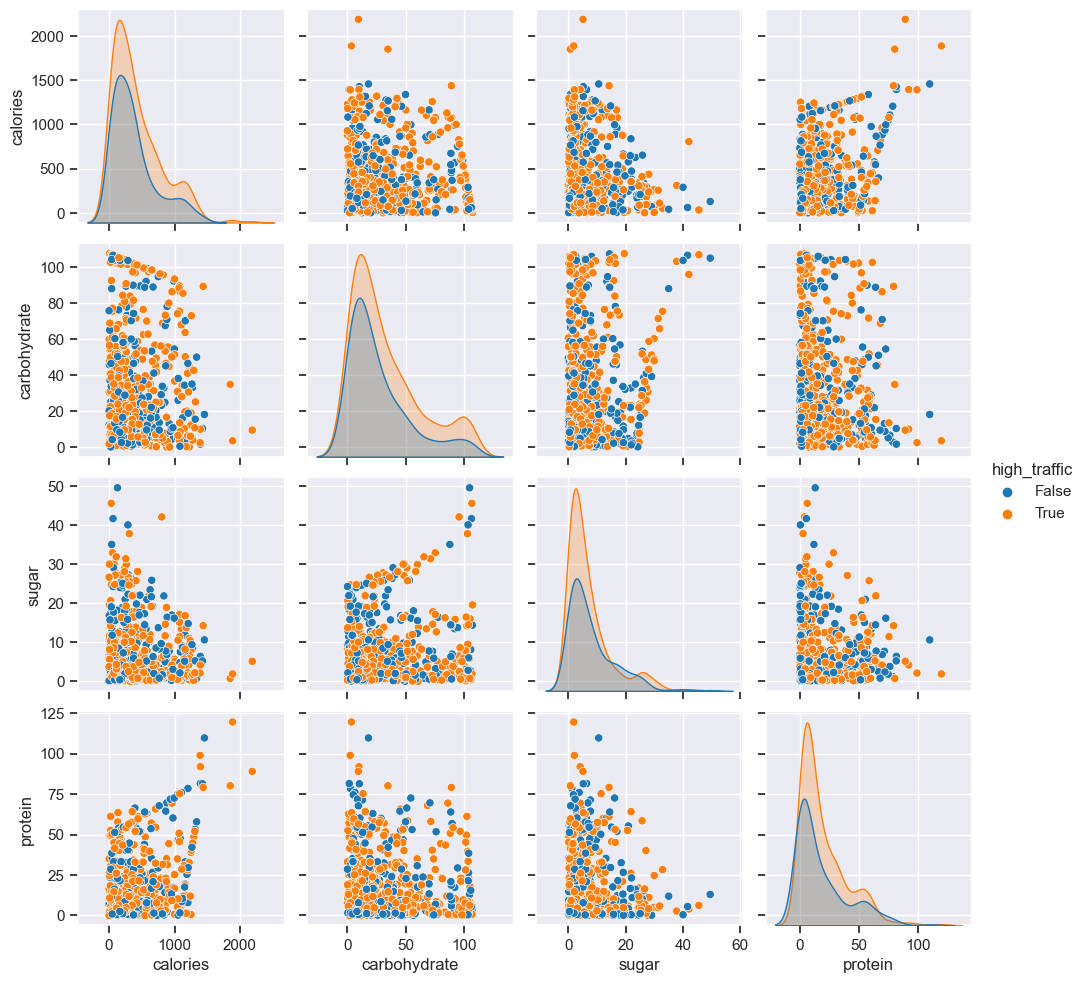

In [42]:
sns.pairplot(data = pd.concat([X_train, y_train], axis=1)[numeric_cols + ['high_traffic'] ], hue = 'high_traffic')

In [43]:
def power_xform(df):
    # Apply a small shift of near zero values to avoid a Box-Cox's strictly greater than zero error
    #print(df[df < 0.01].count())
    df[df < 0.01] = 0.01 
        
    # Apply Box-Cox transform from Scipy Stats package
    df_xform = {}
    maxlog = {}
    for col in numeric_cols:
        df_xform[col], maxlog[col] = scistat.boxcox(df[col])

    # Convert transform to data frame
    df_xform = pd.DataFrame.from_dict(df_xform)
    
    # Correct indexes after transformation
    df_xform.index = df.index
    df_xform = df_xform.add_suffix('_xform')
    
    return df_xform

# Transfrom only the selected numeric columns
X_train[numeric_cols] = power_xform(X_train[numeric_cols].copy())
X_test[numeric_cols] = power_xform(X_test[numeric_cols].copy())

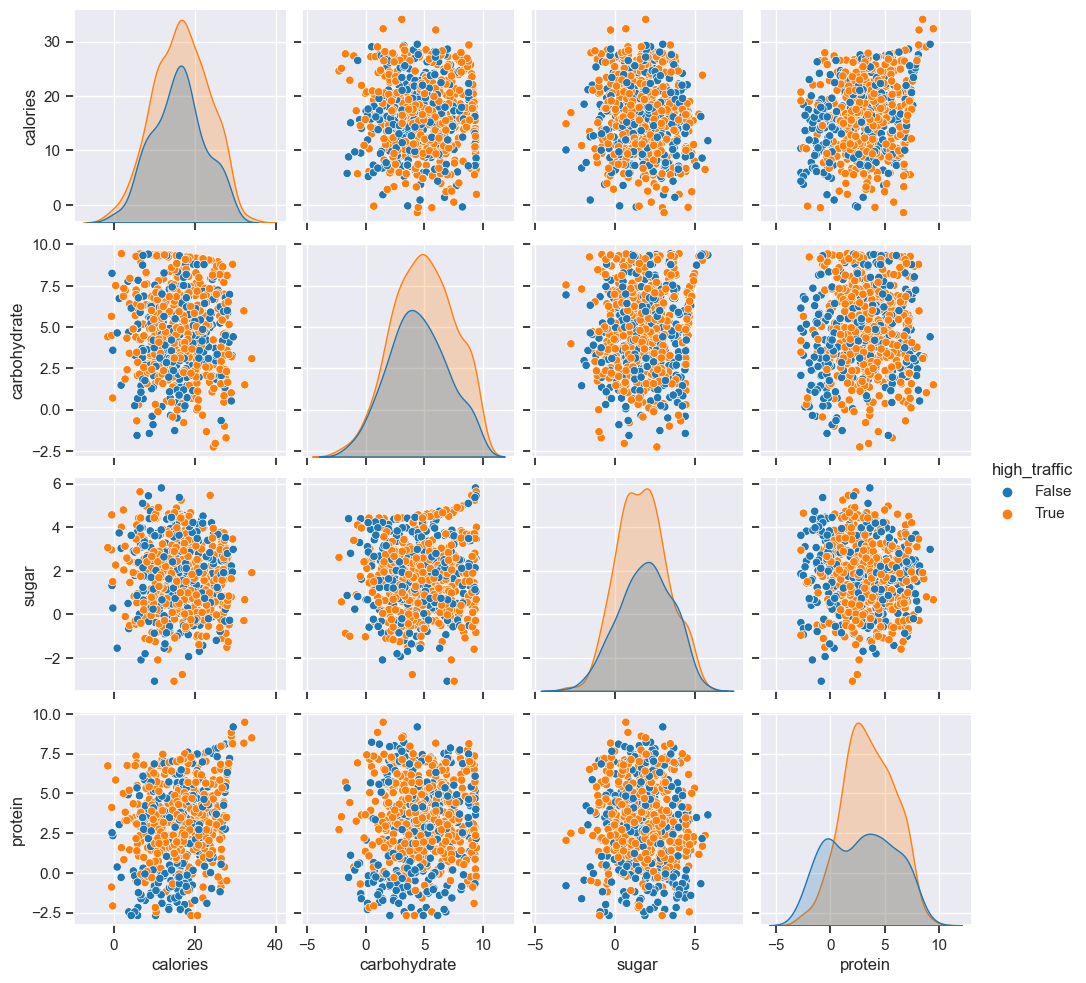

In [44]:
sns.pairplot(data = pd.concat([X_train, y_train], axis=1)[numeric_cols + ['high_traffic'] ], hue = 'high_traffic')

The numeric variables present a more gaussian like distribution, which helps the model at trainning/prediction time. However, we can see the effects of the quantile regressor on the outliers, as they have been laid on the quantile line and this line in turn has been bent by the Box-Cog transform. It is not ideal, but all the points fall within the distribution and limits needed for a better model.

## Normalization

In [45]:
# Normalize train and test set feature columns
scaler = MinMaxScaler()
scaler.fit(X_train[numeric_cols])

X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

print(X_train[numeric_cols].describe())
print('---')
print(X_test[numeric_cols].describe())

         calories  carbohydrate       sugar     protein
count  710.000000    710.000000  710.000000  710.000000
mean     0.501198      0.598465    0.545453    0.488457
std      0.185650      0.217308    0.179081    0.217247
min      0.000000      0.000000    0.000000    0.000000
25%      0.368178      0.445706    0.419116    0.338036
50%      0.503532      0.595826    0.545945    0.487991
75%      0.633216      0.762584    0.668234    0.660377
max      1.000000      1.000000    1.000000    1.000000
---
         calories  carbohydrate       sugar     protein
count  237.000000    237.000000  237.000000  237.000000
mean     0.473350      0.647838    0.517669    0.527670
std      0.184550      0.251206    0.186444    0.219528
min      0.012618      0.045132    0.088996    0.044055
25%      0.328591      0.479275    0.402340    0.360928
50%      0.477917      0.658673    0.522947    0.538596
75%      0.609006      0.807030    0.639432    0.720068
max      0.840469      1.116721    0.972011 

## Convert Categorical Variable to Dummies (One Hot)

Can 'servings' be treated as a category rather than a numeric variable? In order to decide this, there must be no reasonable proportionality dependence between servings and other numeric variables. First we will explore the relationship between the variables visually to check if there is anything that jumps out of the page, and later we will finally decide wether or not a relationship exists through application of statistical tests.

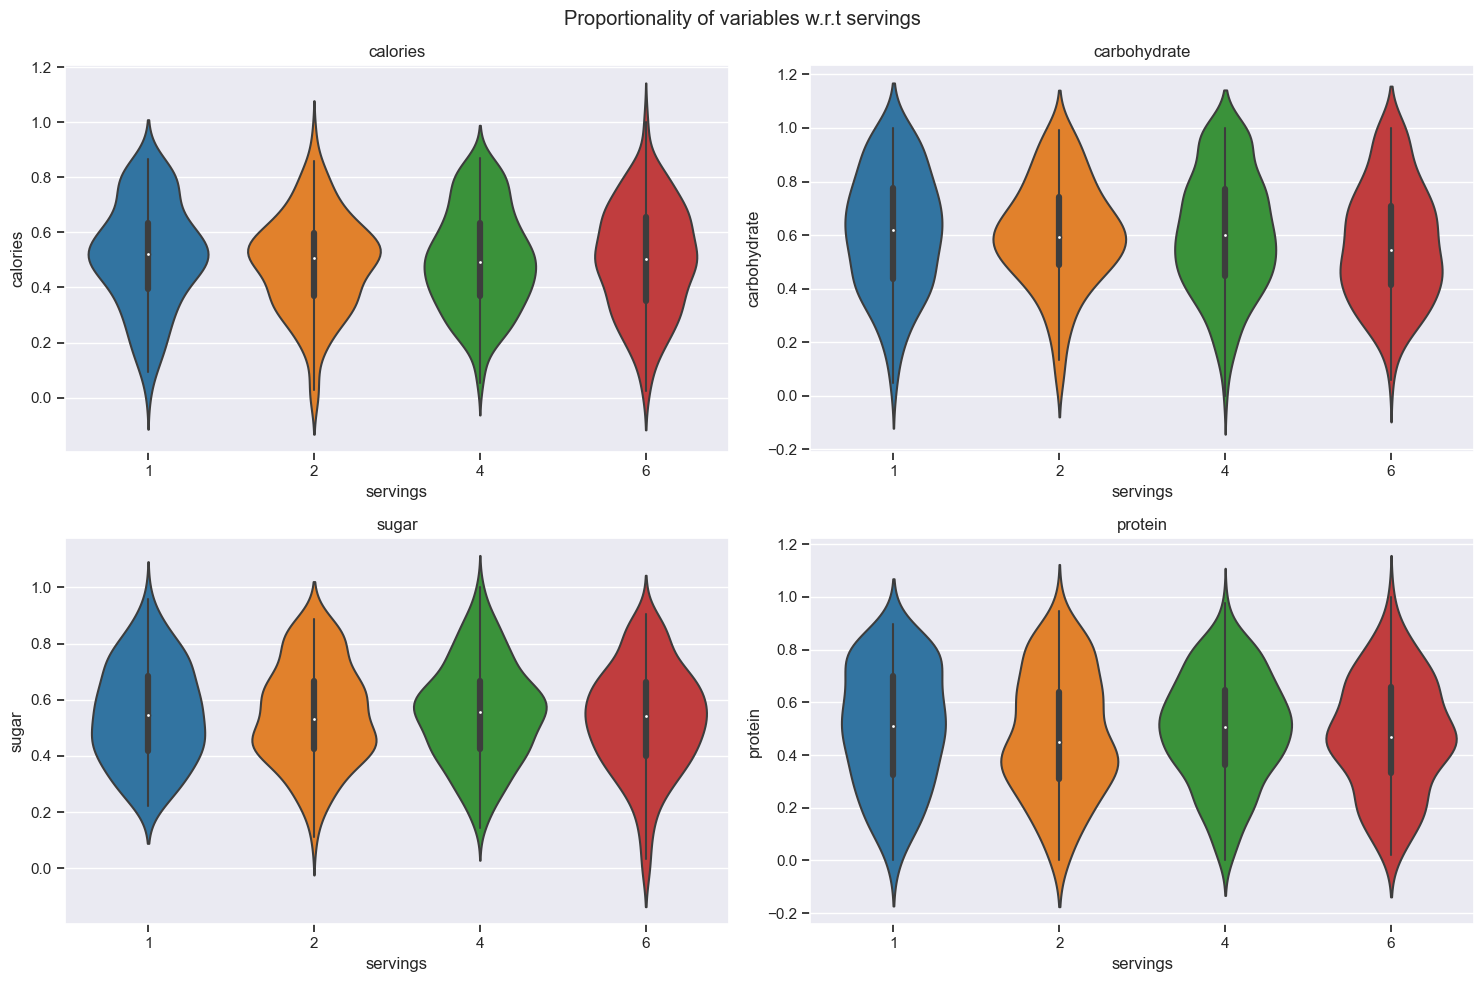

In [46]:
fig, axs = plt.subplots(2,2, figsize=(15,10))
fig.suptitle('Proportionality of variables w.r.t servings')

for idx, col in enumerate(numeric_cols):
    i, j = divmod(idx, 2)
    axs[i, j].set_title(col)
    sns.violinplot(y = col, data=X_train, x="servings", ax=axs[i, j])
    
plt.tight_layout()
plt.show()

There is no discernible dependence of the numerical columns with respect to servings, so this seems to suggest we can treat the 'servings' column as a categorical variable. In order to definitely determine whether we can treat it as a categorical variable, we will perform several statistical tests

Let's asume 'servings' can be treated as a numeric independent variable. In order to test independence of two numeric variable, we use pairwise t-Tests in order to check if the means of numerical columns grouped by servings are statistically greater the greater the serving.

In [47]:
threshold = 0.1
res = {}

for col in numeric_cols:
    print('')
    print('--- T-Tests of ' + col + ' against Servings | Alternative: Greater ---')
    pair_stats = pin.pairwise_tests( data = X_train, dv = col, between = 'servings', padjust="none", alternative = 'greater')
    res[col] = pair_stats
    print(pair_stats.loc[pair_stats['p-unc'] < threshold, :])
    


--- T-Tests of calories against Servings | Alternative: Greater ---
Empty DataFrame
Columns: [Contrast, A, B, Paired, Parametric, T, dof, alternative, p-unc, BF10, hedges]
Index: []

--- T-Tests of carbohydrate against Servings | Alternative: Greater ---
   Contrast  A  B  Paired  ...  alternative     p-unc   BF10    hedges
2  servings  1  6   False  ...      greater  0.043174  1.066  0.204482
4  servings  2  6   False  ...      greater  0.066010  0.777  0.178328
5  servings  4  6   False  ...      greater  0.038135  1.006  0.173367

[3 rows x 11 columns]

--- T-Tests of sugar against Servings | Alternative: Greater ---
   Contrast  A  B  Paired  ...  alternative     p-unc   BF10    hedges
5  servings  4  6   False  ...      greater  0.090704  0.521  0.134593

[1 rows x 11 columns]

--- T-Tests of protein against Servings | Alternative: Greater ---
Empty DataFrame
Columns: [Contrast, A, B, Paired, Parametric, T, dof, alternative, p-unc, BF10, hedges]
Index: []


Only a few group test have a p-value less than our 'generous' threshhold, 0.1:  
- carbohydrates with servings of 1, 2 and 4 against carbohydrates with servings of 6.  
- sugar with servings of 4 against sugars with servings of 6.  
  
For these groups servings acts as another numerical value, and perhaps they could be converted to a carbohdrates_per_serving or sugar_per_serving variable. However, given they are so few, I will ignore them and note this behaviour for future recommendation.  Taking a look at the last pairwise t-test result:

In [48]:
print('--- T-Tests of ' + col + ' against Servings | Alternative: Greater ---')
pair_stats

--- T-Tests of protein against Servings | Alternative: Greater ---


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,servings,1,2,False,True,0.996361,254.702146,greater,0.160010,0.438,0.123961
1,servings,1,4,False,True,0.297622,225.664601,greater,0.383133,0.243,0.032472
2,servings,1,6,False,True,1.146721,268.446587,greater,0.126259,0.488,0.136539
3,servings,2,4,False,True,-0.909504,216.568868,greater,0.817952,0.349,-0.100571
4,servings,2,6,False,True,0.066062,261.286382,greater,0.473690,0.263,0.007930
5,servings,4,6,False,True,1.111548,304.136325,greater,0.133605,0.398,0.111124


We can assert that except for the groups indicated, no other group of any numerical variable has a statistically greater mean as servings increase, we can safely convert 'servings' to a categorical column and One-Hot encode it.

In [49]:
X_train['servings'] = X_train['servings'].astype('category')
X_train = pd.get_dummies(X_train)

X_test['servings'] = X_test['servings'].astype('category')
X_test = pd.get_dummies(X_test)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 710 entries, 413 to 103
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   calories                710 non-null    float64
 1   carbohydrate            710 non-null    float64
 2   sugar                   710 non-null    float64
 3   protein                 710 non-null    float64
 4   category_Beverages      710 non-null    uint8  
 5   category_Breakfast      710 non-null    uint8  
 6   category_Chicken        710 non-null    uint8  
 7   category_Dessert        710 non-null    uint8  
 8   category_Lunch/Snacks   710 non-null    uint8  
 9   category_Meat           710 non-null    uint8  
 10  category_One Dish Meal  710 non-null    uint8  
 11  category_Pork           710 non-null    uint8  
 12  category_Potato         710 non-null    uint8  
 13  category_Vegetable      710 non-null    uint8  
 14  servings_1              710 non-null    

# 5. Model Development

Predicting the *high_traffic* variable is a **binary classification problem**. Several models abound, but the beauty of the Scikit-learn API is that since model fitting, training and evaluation follow the same code, we can reuse it and pile a bunch of models and compare them up rfont without having to reuse code over and over. From the data science point of view, a DecisionTreeClassifier is the go to model for classification problems. All other models may be better or worse, but given the popularity of the DecisionTreeClassifier we will use it as base model and compare against it.

## Fitting and Scoring Several 'Blank' Models at Once

In [53]:
models = []
models.append(('lda', LinearDiscriminantAnalysis()))
models.append(('knn', KNeighborsClassifier()))
models.append(('dtree', DecisionTreeClassifier()))
models.append(('natbayes', GaussianNB()))
models.append(('svm', SVC()))
models.append(('logreg', LogisticRegression()))
models.append(('ridge', RidgeClassifier()))
models.append(('adatree', AdaBoostClassifier(base_estimator=DecisionTreeClassifier())))
models.append(('rndtree', RandomForestClassifier()))
models.append(('linearsvm', LinearSVC()))

In [54]:
model_results = []
model_names = []
model_metric = 'accuracy'
model_params = {}

model_eval = {}

for name, model in models:
     kfold = KFold(n_splits=10)
     cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=model_metric)
     
     model_results.append(cv_results)
     model_names.append(name)
     model_params[name] = model.get_params()
     
     model.fit(X_train, y_train)
     y_pred = model.predict(X_test)
     
     model_eval[name] = [roc_auc_score(y_test,y_pred), accuracy_score(y_test,y_pred), f1_score(y_test,y_pred)]
     
     print("%s train %s -> mean =  %f | std = %f | max = %f" % (name, model_metric, cv_results.mean(), cv_results.std(), cv_results.max()))


lda train accuracy -> mean =  0.754930 | std = 0.052775 | max = 0.816901
knn train accuracy -> mean =  0.722535 | std = 0.055647 | max = 0.802817
dtree train accuracy -> mean =  0.654930 | std = 0.069644 | max = 0.746479
natbayes train accuracy -> mean =  0.678873 | std = 0.072859 | max = 0.788732
svm train accuracy -> mean =  0.722535 | std = 0.040845 | max = 0.774648
logreg train accuracy -> mean =  0.745070 | std = 0.050958 | max = 0.816901
ridge train accuracy -> mean =  0.754930 | std = 0.052775 | max = 0.816901
adatree train accuracy -> mean =  0.597183 | std = 0.070197 | max = 0.704225
rndtree train accuracy -> mean =  0.700000 | std = 0.063318 | max = 0.788732
linearsvm train accuracy -> mean =  0.754930 | std = 0.052775 | max = 0.816901


In [55]:
model_eval_df = pd.DataFrame(model_eval).T
model_eval_df.columns = ['roc_auc', 'accuracy', 'f1']
model_eval_df

,roc_auc,accuracy,f1
lda,0.752631,0.767932,0.814815
knn,0.687309,0.700422,0.756014
dtree,0.644944,0.679325,0.753247
natbayes,0.757322,0.729958,0.751938
svm,0.749009,0.772152,0.822368
logreg,0.744623,0.763713,0.813333
ridge,0.752631,0.767932,0.814815
adatree,0.639529,0.666667,0.737542
rndtree,0.682390,0.708861,0.772277
linearsvm,0.752631,0.767932,0.814815


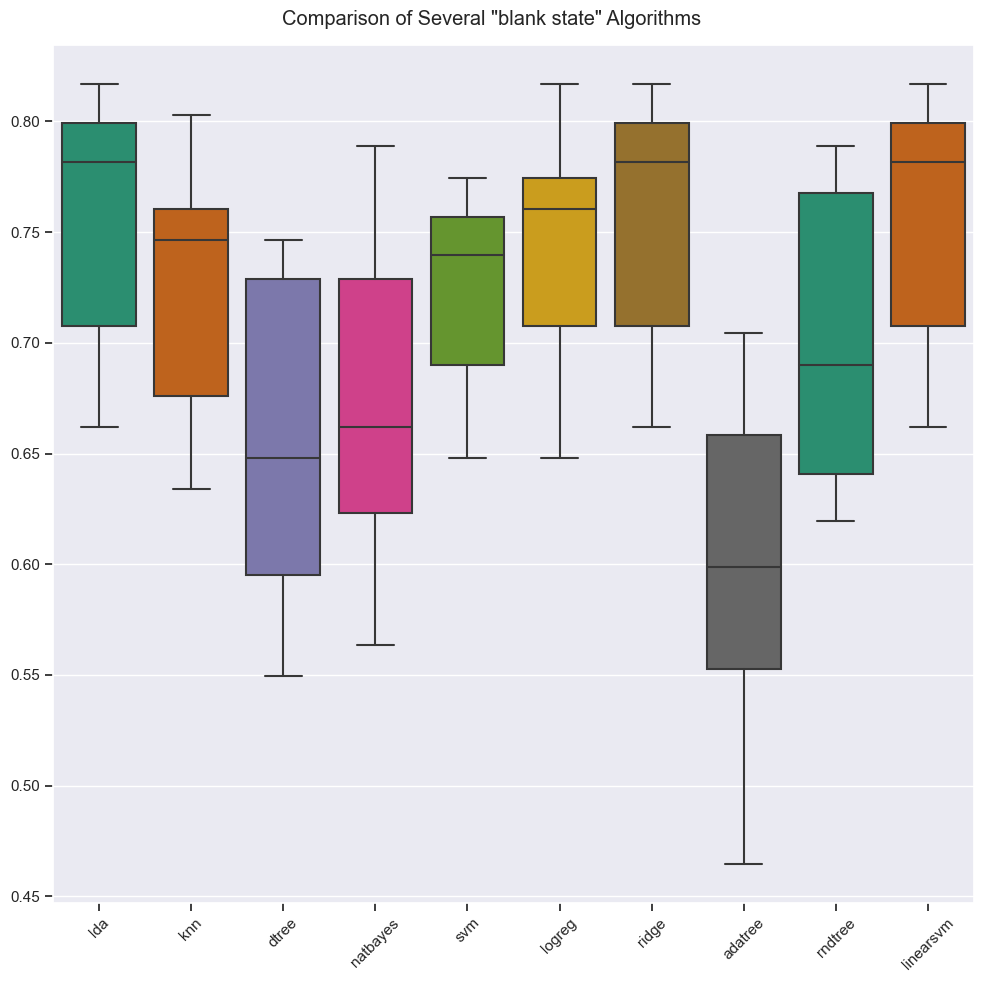

In [56]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Comparison of Several "blank state" Algorithms')

sns.boxplot(model_results, palette = 'Dark2')
ax.set_xticklabels(model_names, rotation = 45)

plt.tight_layout()
plt.show()

## Hyperparameter Tuning

In [57]:
models_2tune = ['lda', 'svm', 'logreg', 'ridge', 'linearsvm']

In [58]:
model_param_grid = {'lda': {
                      'solver': ['svd', 'lsqr', 'eigen'],
                      'store_covariance': [True, False],
                      'shrinkage' : np.linspace(0.0, 1.0, num=20),
                      },
                    'svm': {
                      'C': np.logspace(-3, 3, 7),
                      'gamma': [1,0.1,0.01,0.001],
                      'kernel': ['rbf', 'poly', 'sigmoid'],
                      },
                    'logreg': {
                      'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                      'penalty':['none', 'l1', 'l2', 'elasticnet'],
                      'multi_class': ['auto', 'ovr', 'multinomial'],
                      'C': np.logspace(-3, 3, 7), 
                      'max_iter':[1000]
                      },
                    'ridge': {
                      'alpha': [0.01, 0.1, 1, 10],
                      'fit_intercept': [True, False],
                      'max_iter': [10000]
                      },
                    'linearsvm': {
                      'penalty': ['l1', 'l2'],
                      'loss':['hinge', 'squared_hinge'],
                      'C': np.logspace(-3, 3, 7), 
                      'max_iter':[10000]
                      }
                    }

In [59]:
# With Random Hyperparameter tuning
model_results = []
model_names = []
hyper_model = {}
hyper_model_params = {}

model_eval = {}

for name, model in models:
     if name in models_2tune:
          kfold = KFold(n_splits=10)
          param_space = model_param_grid[name]
     
          hyper_obj = GridSearchCV(model, param_space, scoring = model_metric, cv = kfold)
          hyper_res = hyper_obj.fit(X_train, y_train)
          
          y_pred = hyper_res.predict(X_test)
     
          hyper_model[name] = hyper_res.best_estimator_
          hyper_model_params[name] = hyper_res.best_params_
     
          model_results.append(hyper_res.best_score_)
          model_names.append(name)                          
     
          model_eval[name] = [roc_auc_score(y_test,y_pred), accuracy_score(y_test,y_pred), f1_score(y_test,y_pred)]
     
          print("%s: best %s score =  %f" % (name, model_metric, hyper_res.best_score_))

lda: best accuracy score =  0.760563
svm: best accuracy score =  0.761972
logreg: best accuracy score =  0.749296
ridge: best accuracy score =  0.754930
linearsvm: best accuracy score =  0.760563


In [60]:
model_eval_df = pd.DataFrame(model_eval).T
model_eval_df.columns = ['roc_auc', 'accuracy', 'f1']
model_eval_df

,roc_auc,accuracy,f1
lda,0.746949,0.763713,0.812081
svm,0.746949,0.763713,0.812081
logreg,0.752631,0.767932,0.814815
ridge,0.752631,0.767932,0.814815
linearsvm,0.752631,0.767932,0.814815


# 6. Model Evaluation

## Model 1: Decision Tree Classifier

In [61]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)
print('Classification Report: ')
print(classification_report(y_test,y_pred))
print('ROC-AUC Score:', roc_auc_score(y_test,y_pred).round(3))
print('Accuracy Score:', accuracy_score(y_test,y_pred).round(3))
print('F1 Score:', f1_score(y_test,y_pred).round(3))

Classification Report: 
              precision    recall  f1-score   support

       False       0.58      0.53      0.56        88
        True       0.74      0.77      0.75       149

    accuracy                           0.68       237
   macro avg       0.66      0.65      0.66       237
weighted avg       0.68      0.68      0.68       237

ROC-AUC Score: 0.653
Accuracy Score: 0.684
F1 Score: 0.754


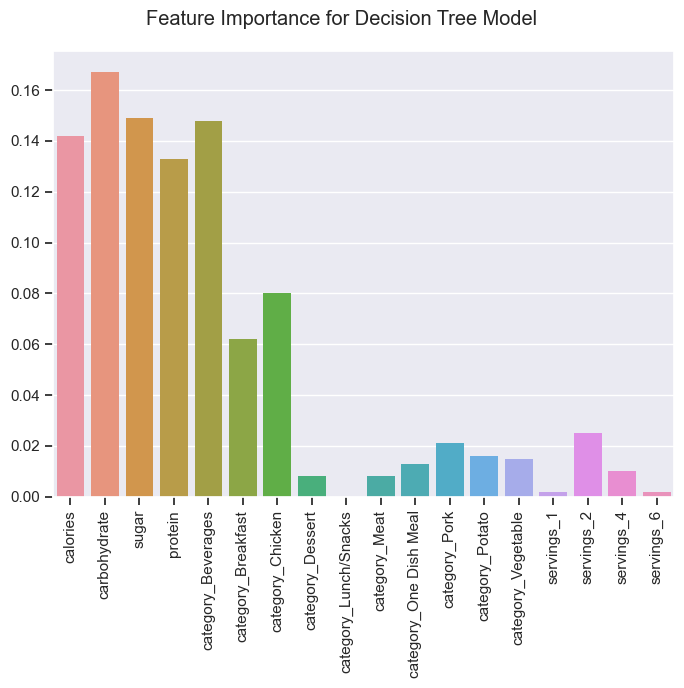

In [62]:
importances = pd.DataFrame(dict(zip(X_train.columns,dtree.feature_importances_.round(3))), index=[0])

fig, ax = plt.subplots(figsize=(7,7))
fig.suptitle('Feature Importance for Decision Tree Model')

sns.barplot(importances, ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')

plt.tight_layout()
plt.show()


## Model 2: Support Vector Classification

In [63]:
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print('Classification Report: ')
print(classification_report(y_test,y_pred))
print('ROC-AUC Score:', roc_auc_score(y_test,y_pred).round(3))
print('Accuracy Score:', accuracy_score(y_test,y_pred).round(3))
print('F1 Score:', f1_score(y_test,y_pred).round(3))

Classification Report: 
              precision    recall  f1-score   support

       False       0.71      0.66      0.68        88
        True       0.81      0.84      0.82       149

    accuracy                           0.77       237
   macro avg       0.76      0.75      0.75       237
weighted avg       0.77      0.77      0.77       237

ROC-AUC Score: 0.749
Accuracy Score: 0.772
F1 Score: 0.822


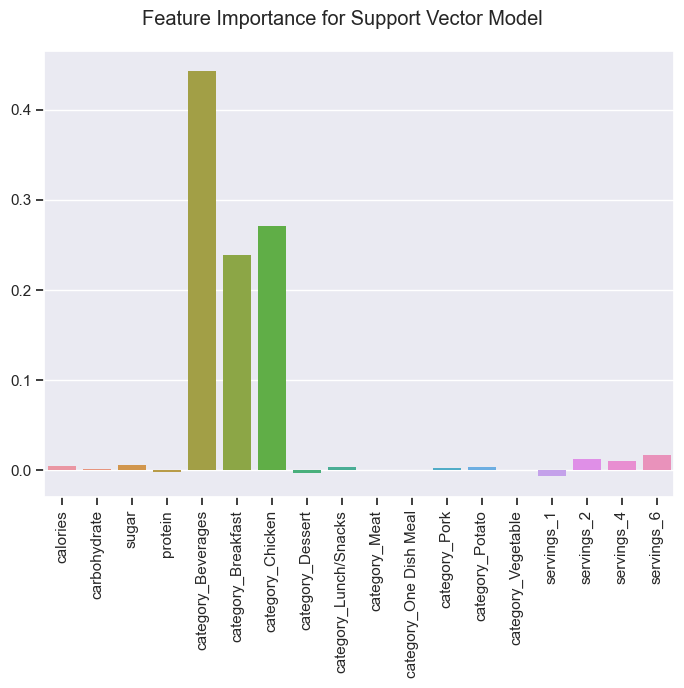

In [65]:
perm_importance = permutation_importance(svm, X_train, y_train)
perm_importance_normalized = perm_importance.importances_mean/perm_importance.importances_mean.sum()

features = np.array(X_train.columns)

fig, ax = plt.subplots(figsize=(7,7))
fig.suptitle('Feature Importance for Support Vector Model')

sns.barplot(x = features, y = perm_importance_normalized, ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')

plt.tight_layout()
plt.show()


## Model 3: Linear Discriminant Analysis

In [66]:
hyper_model_params['lda']

{'shrinkage': 0.5263157894736842, 'solver': 'lsqr', 'store_covariance': True}

In [67]:
lda = LinearDiscriminantAnalysis(shrinkage= 0.5263157894736842, solver= 'lsqr', store_covariance= True)
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
print('Classification Report: ')
print(classification_report(y_test,y_pred))
print('ROC-AUC Score:', roc_auc_score(y_test,y_pred).round(3))
print('Accuracy Score:', accuracy_score(y_test,y_pred).round(3))
print('F1 Score:', f1_score(y_test,y_pred).round(3))

Classification Report: 
              precision    recall  f1-score   support

       False       0.68      0.68      0.68        88
        True       0.81      0.81      0.81       149

    accuracy                           0.76       237
   macro avg       0.75      0.75      0.75       237
weighted avg       0.76      0.76      0.76       237

ROC-AUC Score: 0.747
Accuracy Score: 0.764
F1 Score: 0.812


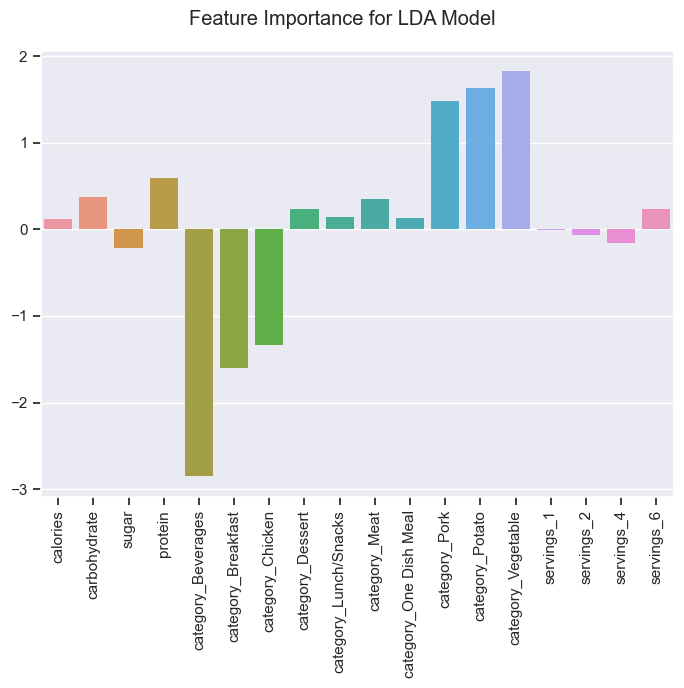

In [68]:
importances = pd.DataFrame(dict(zip(X_train.columns,lda.coef_.round(3)[0])), index=[0])

fig, ax = plt.subplots(figsize=(7,7))
fig.suptitle('Feature Importance for LDA Model')

sns.barplot(importances, ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')

plt.tight_layout()
plt.show()


# 7. Business Focus & Metric

The business had specified the following requirements:  
- *Predict which recipes will lead to high traffic*
- *Correctly predict high traffic recipes 80% of the time*

The first requirement is met by developing a model, tuning its parameters and storing it for later consumption against the database of the stored recipes. Given the analysis performed, we recommend the **Support Vector Calssification Model** be used for this task. The second requirement is met by looking at the evaluation metrics gathered: ROC_AUC and Accuracy are around the 75% mark, but the **F1 Score**, which is a harmonic mean of Precision and Recall, consistently exceeds the 80%, providing a reliable predicciont of which recipes will lead to high traffic greater than 80% of the time.


## KPI and KPI estimation for the current data

Given that according to the requirements/specifications the business does not seem to care about false negatives or false positives, then **Accuracy** should be the metric to monitor as new recipes are predicted and new data is gathered from the traffic to the rest of the website. The proposed model for production, **SVC**, has an accuracy on training data of 77.2 %, whereas the next best model, **LDA**, has an accuracy on training data of 76.8%. Estimating their *accuracy* on the whole dataset we have:

In [69]:
X = pd.concat([X_train, X_test], axis = 0) 
y = pd.concat([y_train, y_test], axis = 0) 

y_pred_svm = svm.predict(X)
y_pred_lda = lda.predict(X)

print('SVM Accuracy Score:', accuracy_score(y,y_pred_svm).round(3))
print('LDA Accuracy Score:', accuracy_score(y,y_pred_lda).round(3))

SVM Accuracy Score: 0.768
LDA Accuracy Score: 0.76


# 8. Conclusions

## Recommendations to the Product Manager & Head of DS

The SVC model can be deployed to production to help the product manager choose which recipes to display in the website. The model predicts **82%** correctly a high or low traffic inducing recipe. 

In addition to this recommendation, the following data is probably readily available and could probably enrich the dataset and the model at little to no cost:  
    - **Time to Make**: It is already displayed in the recipes, perhaps some recipes lead to higher traffic just because they are either simpler, or need ingredientes offered elsewhere in the site.  
    - **Cost per serving**: Also significant for high traffic recipes.  
    - **List of ingredients**: Readily available as part of the recipe.  
    - **Date of publication**: There is a strong correlation of Vegetables, Potatoes and Pork w.r.t. higher traffic. Perhaps this data was sampled during winter? Including this data could help build models that also predict higher traffic leading recipes at different times of the year, thus helping further the product manager.  

Finally, some feature ingeneering, balancing by resampling / bootstrapping, and checking the true origin of the outliers could greatly improve the predictions and the model hereby presented.  

## Final Remarks